In [13]:
import json
import os
import subprocess
import sys

from pathlib import Path
from IPython.display import display, display_pdf, Image
from IPython.display import IFrame
from PIL import Image as PImage

import sycamore
from sycamore.data import Document
from sycamore.transforms.embed import SentenceTransformerEmbedder
from sycamore.transforms.extract_entity import OpenAIEntityExtractor
from sycamore.llms import OpenAIModels, OpenAI, LLM
from sycamore.transforms.partition import SycamorePartitioner, ArynPartitioner
from sycamore.llms.prompts.default_prompts import TEXT_SUMMARIZER_GUIDANCE_PROMPT_CHAT
from sycamore.transforms.summarize import Summarizer
from sycamore.transforms.extract_table import TextractTableExtractor
from sycamore.functions.document import split_and_convert_to_image, DrawBoxes
from sycamore.tests.config import TEST_DIR
from sycamore.transforms.merge_elements import GreedyTextElementMerger
from sycamore.functions.tokenizer import HuggingFaceTokenizer
from sycamore.connectors.file.file_scan import JsonManifestMetadataProvider

from sycamore.utils.pdf_utils import show_pages
import nltk

from ray.data import ActorPoolStrategy

sycamore.llms.prompts.default_prompts - WARNING - 2024-07-11 23:15:27,357 - The prompt TEXT_SUMMARIZER_GUIDANCE_PROMPT_CHAT is deprecated. Switch to TextSummarizerGuidancePrompt()


In [2]:
# %%bash
# mkdir -p visualize_pdfs
# curl https://investors.3m.com/financials/sec-filings/content/0001558370-19-000470/0001558370-19-000470.pdf -o visualize_pdfs/3m_1.pdf

In [2]:
if os.path.exists("/.dockerenv"):
    # Running in Docker.
    work_dir = "/visualize_pdfs"
else:
    # Running outside of docker. This will land under notebooks/data/
    work_dir = "./data"
work_dir = "/visualize_pdfs"

In [14]:
from sycamore.transforms.table_structure.extract import TableTransformerStructureExtractor


def partition_visualize(paths, tables, thrshld=0.3):
    if len(paths) == 0:
        print("WARNING: import_pdf called with empty paths")
    
    if (
        (isinstance(paths, str) or isinstance(paths, Path)) 
        and Path(paths).exists() and Path(paths).is_dir()
        and len(list(Path(paths).iterdir())) == 0
    ):
        print("WARNING: import_pdf called with empty directory")
    
    ctx = sycamore.init()
    pdf_docset = ctx.read.binary(paths, binary_format="pdf", filter_paths_by_extension=False)
    tablex=TextractTableExtractor(profile_name="AdministratorAccess-237550789389", region_name="us-east-1", s3_upload_root="s3://aanya-textract")
    partitioned_docset = pdf_docset.partition(partitioner=SycamorePartitioner(extract_table_structure=tables, threshold=thrshld, use_ocr=False), table_extractor=tablex, compute=ActorPoolStrategy(size=1))
    
    show_pages(partitioned_docset, limit=1)
    # partitioned_docset.show(limit=1000000)
    return partitioned_docset.take_all()

2024-07-11 23:15:36,815	WARNING util.py:560 -- The argument ``compute`` is deprecated in Ray 2.9. Please specify argument ``concurrency`` instead. For more information, see https://docs.ray.io/en/master/data/transforming-data.html#stateful-transforms.
2024-07-11 23:15:36,820	INFO streaming_executor.py:112 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-07-11_21-20-21_872341_7631/logs/ray-data
2024-07-11 23:15:36,821	INFO streaming_executor.py:113 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadBinary] -> TaskPoolMapOperator[Map(BinaryScan._to_document)] -> ActorPoolMapOperator[MapBatches(BaseMapTransformCallable___wrap)] -> TaskPoolMapOperator[MapBatches(_wrap)->MapBatches(split_and_convert_to_image)] -> LimitOperator[limit=1] -> TaskPoolMapOperator[MapBatches(DrawBoxes)]


- ReadBinary->SplitBlocks(16) 1:   0%|          | 0/1 [00:00<?, ?it/s]

- Map(BinaryScan._to_document) 2:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(BaseMapTransformCallable___wrap) 3:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(_wrap)->MapBatches(split_and_convert_to_image) 4:   0%|          | 0/1 [00:00<?, ?it/s]

- limit=1 5:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(DrawBoxes) 6:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

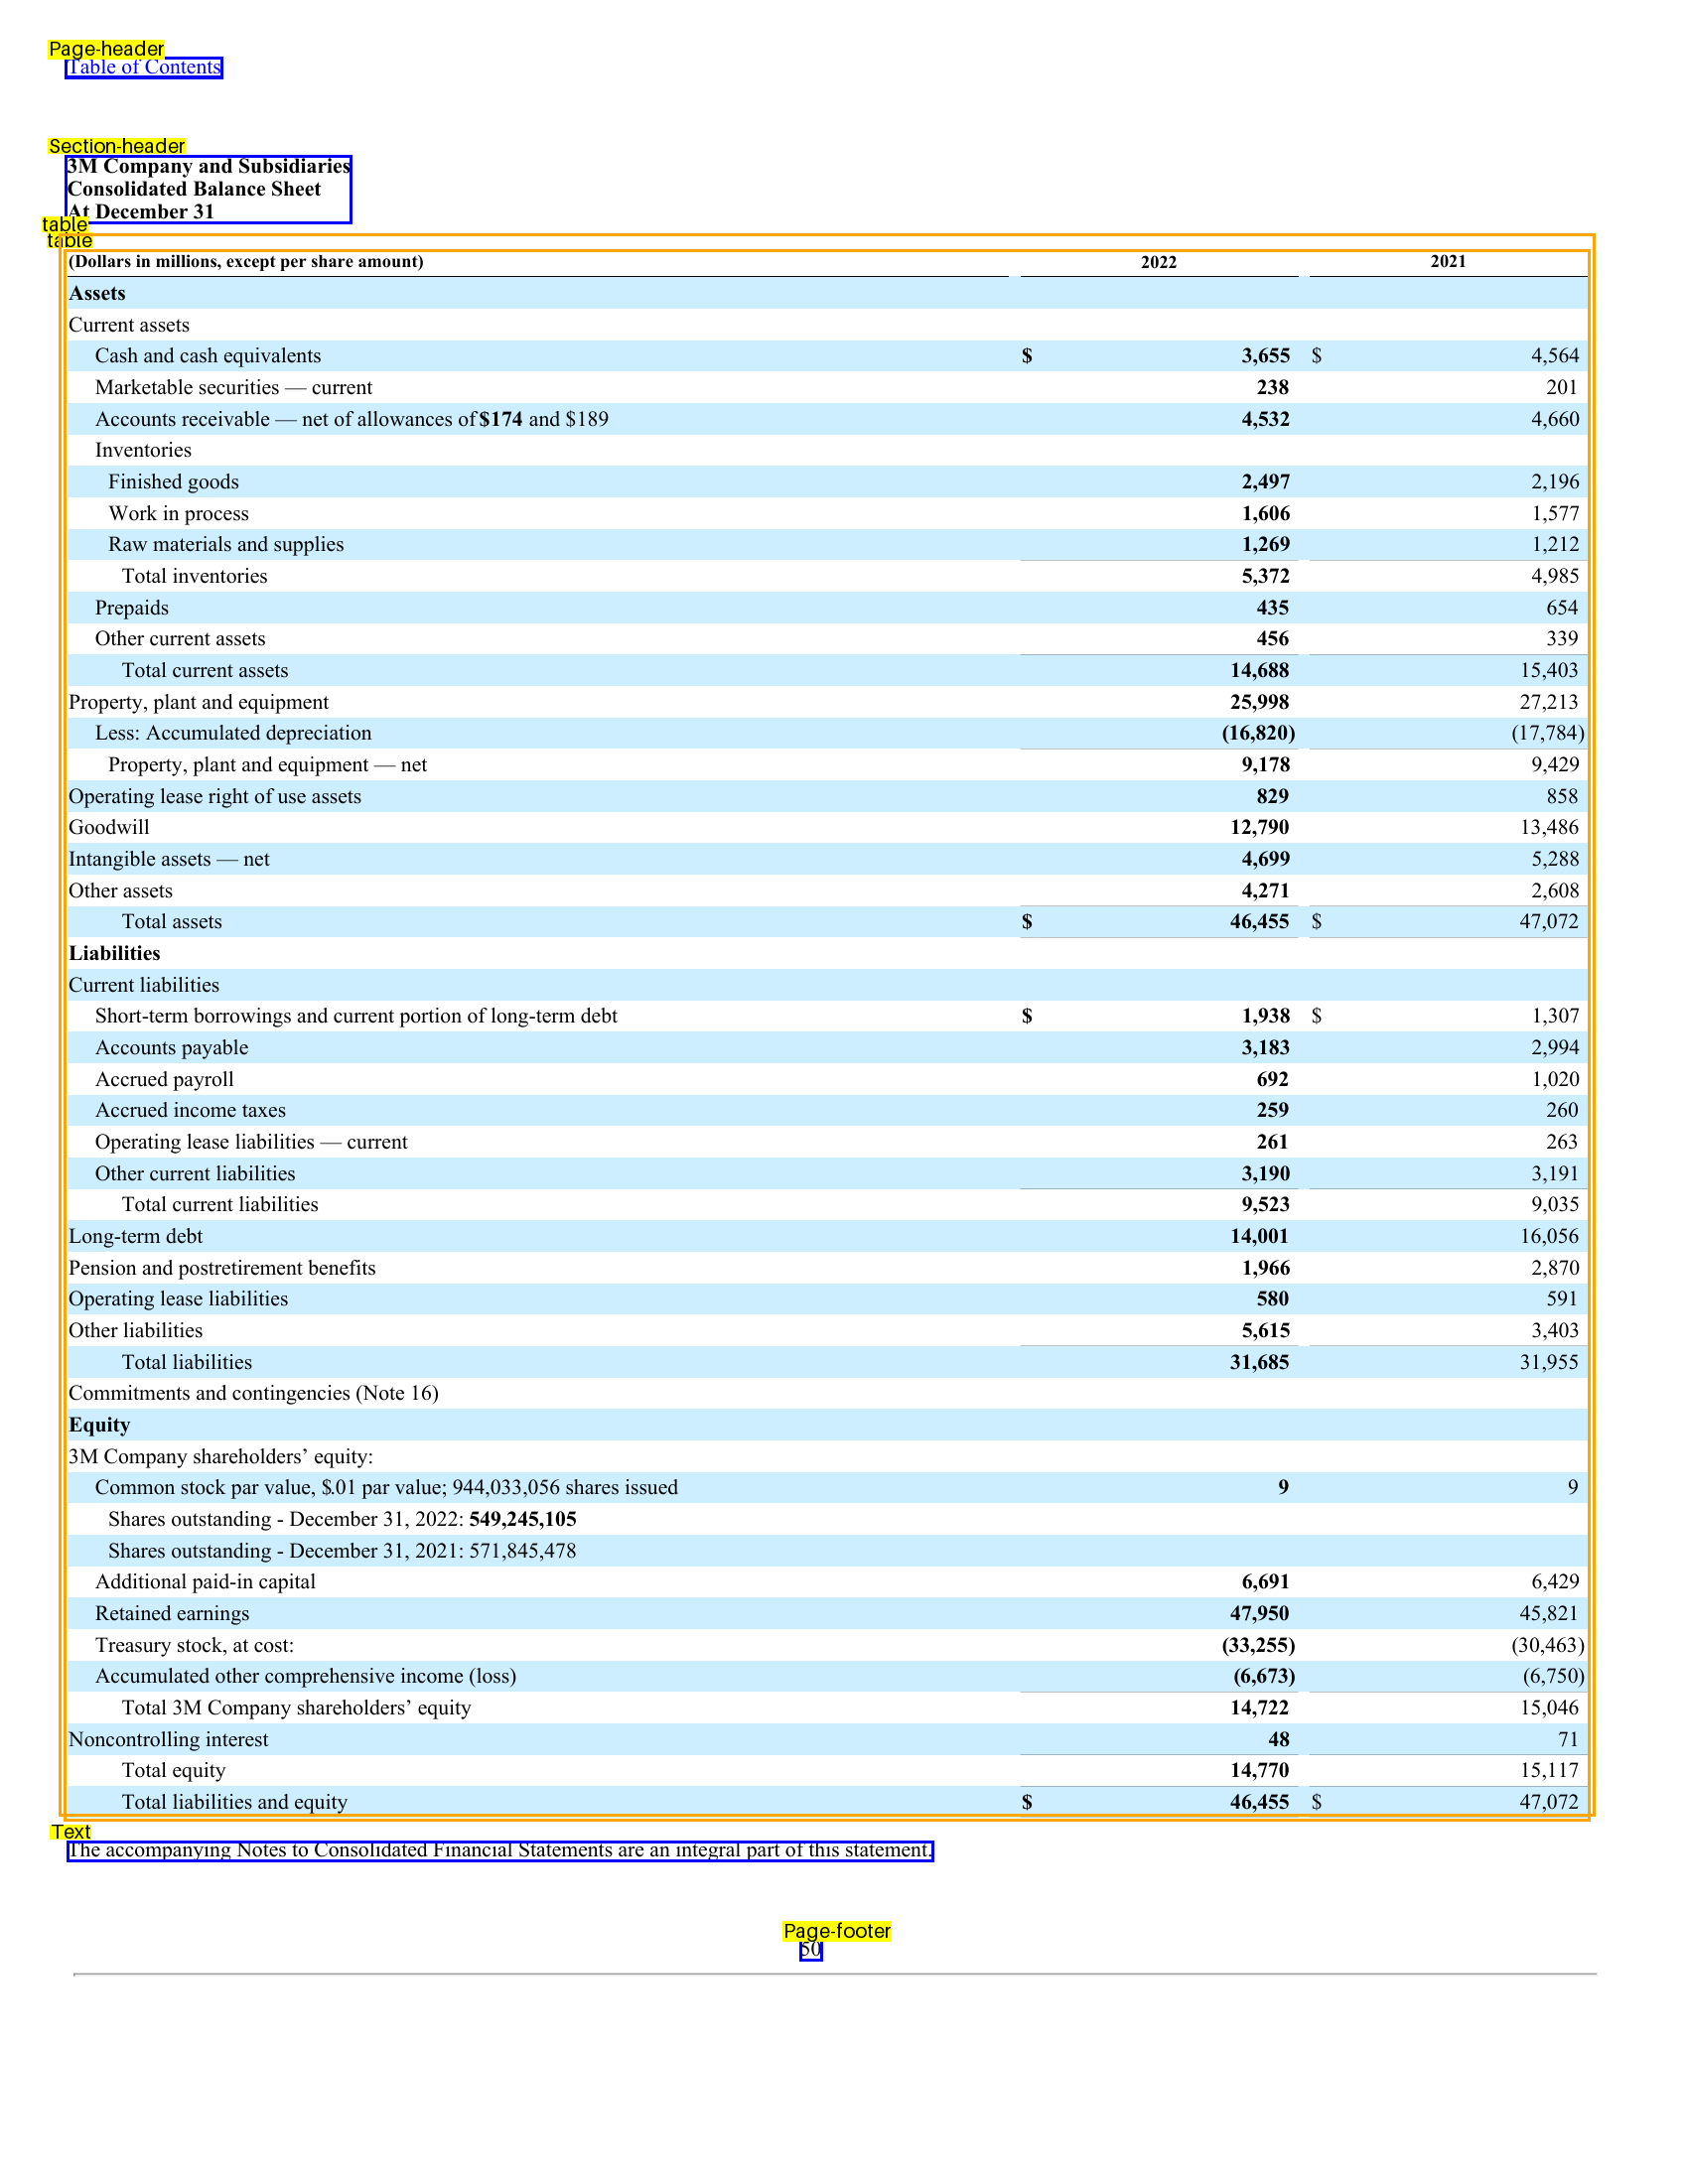

2024-07-11 23:16:06,746	WARNING util.py:560 -- The argument ``compute`` is deprecated in Ray 2.9. Please specify argument ``concurrency`` instead. For more information, see https://docs.ray.io/en/master/data/transforming-data.html#stateful-transforms.
2024-07-11 23:16:06,749	INFO streaming_executor.py:112 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-07-11_21-20-21_872341_7631/logs/ray-data
2024-07-11 23:16:06,750	INFO streaming_executor.py:113 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadBinary] -> TaskPoolMapOperator[Map(BinaryScan._to_document)] -> ActorPoolMapOperator[MapBatches(BaseMapTransformCallable___wrap)] -> TaskPoolMapOperator[MapBatches(_wrap)]


- ReadBinary->SplitBlocks(16) 1:   0%|          | 0/1 [00:00<?, ?it/s]

- Map(BinaryScan._to_document) 2:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(BaseMapTransformCallable___wrap) 3:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(_wrap) 4:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

[{'properties': {'path': '/home/admin/sycamore/examples/visualize_pdfs/3m_table3.pdf', 'filetype': 'application/pdf'}, 'elements': [{'type': 'Page-header', 'bbox': (0.03874198015998392, 0.026157691261985087, 0.1318423641429228, 0.03633919455788352), 'properties': {'score': 0.7613633275032043, 'page_number': 1}, 'text_representation': 'Table of Contents\n'}, {'type': 'Section-header', 'bbox': (0.03878365460564109, 0.0711107704856179, 0.20858653349034925, 0.10243786898526279), 'properties': {'score': 0.6944294571876526, 'page_number': 1}, 'text_representation': '3M Company and Subsidiaries\nConsolidated Balance Sheet\nAt December 31\n'}, {'type': 'table', 'bbox': (0.03779166726505055, 0.11413195523348722, 0.9418276079963235, 0.834015946821733), 'properties': {'score': 0.9210178852081299, 'title': None, 'columns': None, 'rows': None, 'page_number': 1}, 'text_representation': '(Dollars in millions, except per share amount)\n 2022\n 2021\n Assets\nCurrent assets\n Cash and cash equivalents\

In [15]:
# Title page, 3M 10K
# doc_ocr_new = partition_visualize("/home/admin/sycamore/examples/visualize_pdfs/3m_table.pdf", True, 0.3)
# doc_ocr_new
doc_ocr_q3 = partition_visualize("/home/admin/sycamore/examples/visualize_pdfs/3m_table3.pdf", False, 0.3)
doc_ocr_q3

In [16]:
for i in doc_ocr_q3[0].elements:
    if i.type == 'table':
        print (i.text_representation)

(Dollars in millions, except per share amount)
 2022
 2021
 Assets
Current assets
 Cash and cash equivalents
Marketable securities — current
Accounts receivable — net of allowances of $174 and $189
Inventories
 Finished goods
Work in process
Raw materials and supplies
 Total inventories
 Prepaids
Other current assets
 Total current assets
Property, plant and equipment
 Less: Accumulated depreciation
 Property, plant and equipment — net
 Operating lease right of use assets
Goodwill
Intangible assets — net
Other assets
 Total assets
 Liabilities
Current liabilities
 Short-term borrowings and current portion of long-term debt
Accounts payable
Accrued payroll
Accrued income taxes
Operating lease liabilities — current
Other current liabilities
 Total current liabilities
 Long-term debt
Pension and postretirement benefits
Operating lease liabilities
Other liabilities
 Total liabilities
 Commitments and contingencies (Note 16)
Equity
3M Company shareholders’ equity:
 Common stock par value, $

In [16]:
for i in doc1[0].elements:
    if i.type == 'table':
        print (i.text_representation)

(Millions)
Cash Flows from Operating Activities
Net income including noncontrolling interest
Adjustments to reconcile net income including noncontrolling interest to net cash
 2018
 2017
 2016
   $
 5,363   $
 4,869   $
 5,058  
 provided by operating activities
Depreciation and amortization
Company pension and postretirement contributions
Company pension and postretirement expense
Stock-based compensation expense
Gain on sale of businesses
Deferred income taxes
Changes in assets and liabilities
 Accounts receivable
Inventories
Accounts payable
Accrued income taxes (current and long-term)
 Other — net
 Net cash provided by (used in) operating activities
 Cash Flows from Investing Activities
Purchases of property, plant and equipment (PP&E)
Proceeds from sale of PP&E and other assets
Acquisitions, net of cash acquired
Purchases of marketable securities and investments
Proceeds from maturities and sale of marketable securities and investments
Proceeds from sale of businesses, net of cash

In [21]:
for i in doc2[0].elements:
    if i.type == 'table':
        print (i.table.to_csv())

(Millions),2018,2017,2016
Cash Flows Operating Activities from,,,
"Net income including noncontrolling interest 5,363 4.869 5,058",,,
Adjustments to reconcile net income including noncontrolling interest to net cash provided by operating activities,,,
Depreciation and amortization,"1,488","1,544","1,474"
Company pension and postretirement contributions,(370),967),(383)
Company pension and postretirement expense,410,334,250
Stock-based compensation expense,302,324,298
Gain on sale of businesses,(545),(586),(111)
Deferred income taxes,(57),107,
Changes in assets and liabilities,,,
Accounts receivable,(305),(245),(313)
Inventories,(509),(387),57
Accounts payable,408,24,148
Accrued income taxes current and term) long-',134,967,101
Other net,120,256,76
Net cash provided by (used in) operating activities,"6,439","6,240",66_
Cash Flows from Investing Activities,,,
"Purchases of property, plant and equipment (PP&E)","(1,577)","(1,373)","1,420)"
Proceeds from sale of PP&E and other assets,262,4

In [4]:
def is_consolidated(elements, table_idx):
    prev = range(table_idx-5, table_idx) if table_idx > 5 else range(table_idx)
    for j in prev:
        if (elements[j].text_representation is not None) and ("Consolidated" in elements[j].text_representation):
            return True

def ocr_table(table):
    pass

In [5]:
elems = doc[0].elements
for i in range(len(elems)):
    if elems[i].type == 'table':
        if is_consolidated(elems, i):
            pass

In [6]:
from sycamore.data.element import TableElement


# print (isinstance(doc[0].elements[3], TableElement))
# print (doc[0].elements[3])
doc

[{'properties': {'path': '/home/admin/sycamore/examples/visualize_pdfs/3m_1.pdf', 'filetype': 'application/pdf'}, 'elements': [{'type': 'Page-header', 'bbox': (0.09254883710075827, 0.02588048761541193, 0.18516457950367646, 0.036462620821866125), 'properties': {'score': 0.7105238437652588, 'page_number': 1}, 'text_representation': ''}, {'type': 'Section-header', 'bbox': (0.0923248291015625, 0.0672761327570135, 0.3043683220358456, 0.09994891079989347), 'properties': {'score': 0.4793054163455963, 'page_number': 1}, 'text_representation': '3M Company and Subsidiaries\nConsolidated Statement of Cash Flows\nYears ended December 31\n'}, {'type': 'Section-header', 'bbox': (0.09287836411420036, 0.0673000127618963, 0.2605581844554228, 0.07790306784889915), 'properties': {'score': 0.3135610818862915, 'page_number': 1}, 'text_representation': '3M Company and Subsidiaries\n'}, {'type': 'table', 'bbox': (0.0904532668169807, 0.11156481656161221, 0.8908106186810661, 0.6249001242897727), 'properties': 

2024-07-10 22:26:26,414	WARNING util.py:560 -- The argument ``compute`` is deprecated in Ray 2.9. Please specify argument ``concurrency`` instead. For more information, see https://docs.ray.io/en/master/data/transforming-data.html#stateful-transforms.
2024-07-10 22:26:26,421	INFO streaming_executor.py:112 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-07-10_22-25-44_664218_148065/logs/ray-data
2024-07-10 22:26:26,421	INFO streaming_executor.py:113 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadBinary] -> TaskPoolMapOperator[Map(BinaryScan._to_document)] -> ActorPoolMapOperator[MapBatches(BaseMapTransformCallable___wrap)] -> TaskPoolMapOperator[MapBatches(split_and_convert_to_image)] -> LimitOperator[limit=1] -> TaskPoolMapOperator[MapBatches(DrawBoxes)]


- ReadBinary->SplitBlocks(16) 1:   0%|          | 0/1 [00:00<?, ?it/s]

- Map(BinaryScan._to_document) 2:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(BaseMapTransformCallable___wrap) 3:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(split_and_convert_to_image) 4:   0%|          | 0/1 [00:00<?, ?it/s]

- limit=1 5:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(DrawBoxes) 6:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

(MapWorker(MapBatches(BaseMapTransformCallable___wrap)) pid=148970) The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
(MapWorker(MapBatches(BaseMapTransformCallable___wrap)) pid=148970) /home/admin/.cache/pypoetry/virtualenvs/sycamore-monorepo-RdRTS9RD-py3.11/lib/python3.11/site-packages/torch/utils/cpp_extension.py:1967: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
(MapWorker(MapBatches(BaseMapTransformCallable___wrap)) pid=148970) If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
(MapWorker(MapBatches(BaseMapTransformCallable___wrap)) pid=148970)   warnings.warn(
(MapWorker(MapBatches(BaseMapTransformCallable___wrap)) pid=149079) The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
(MapWorker(MapBatches(BaseMapTransformCallable___wrap)) pid=149079) /home/admin/.cache/pypo

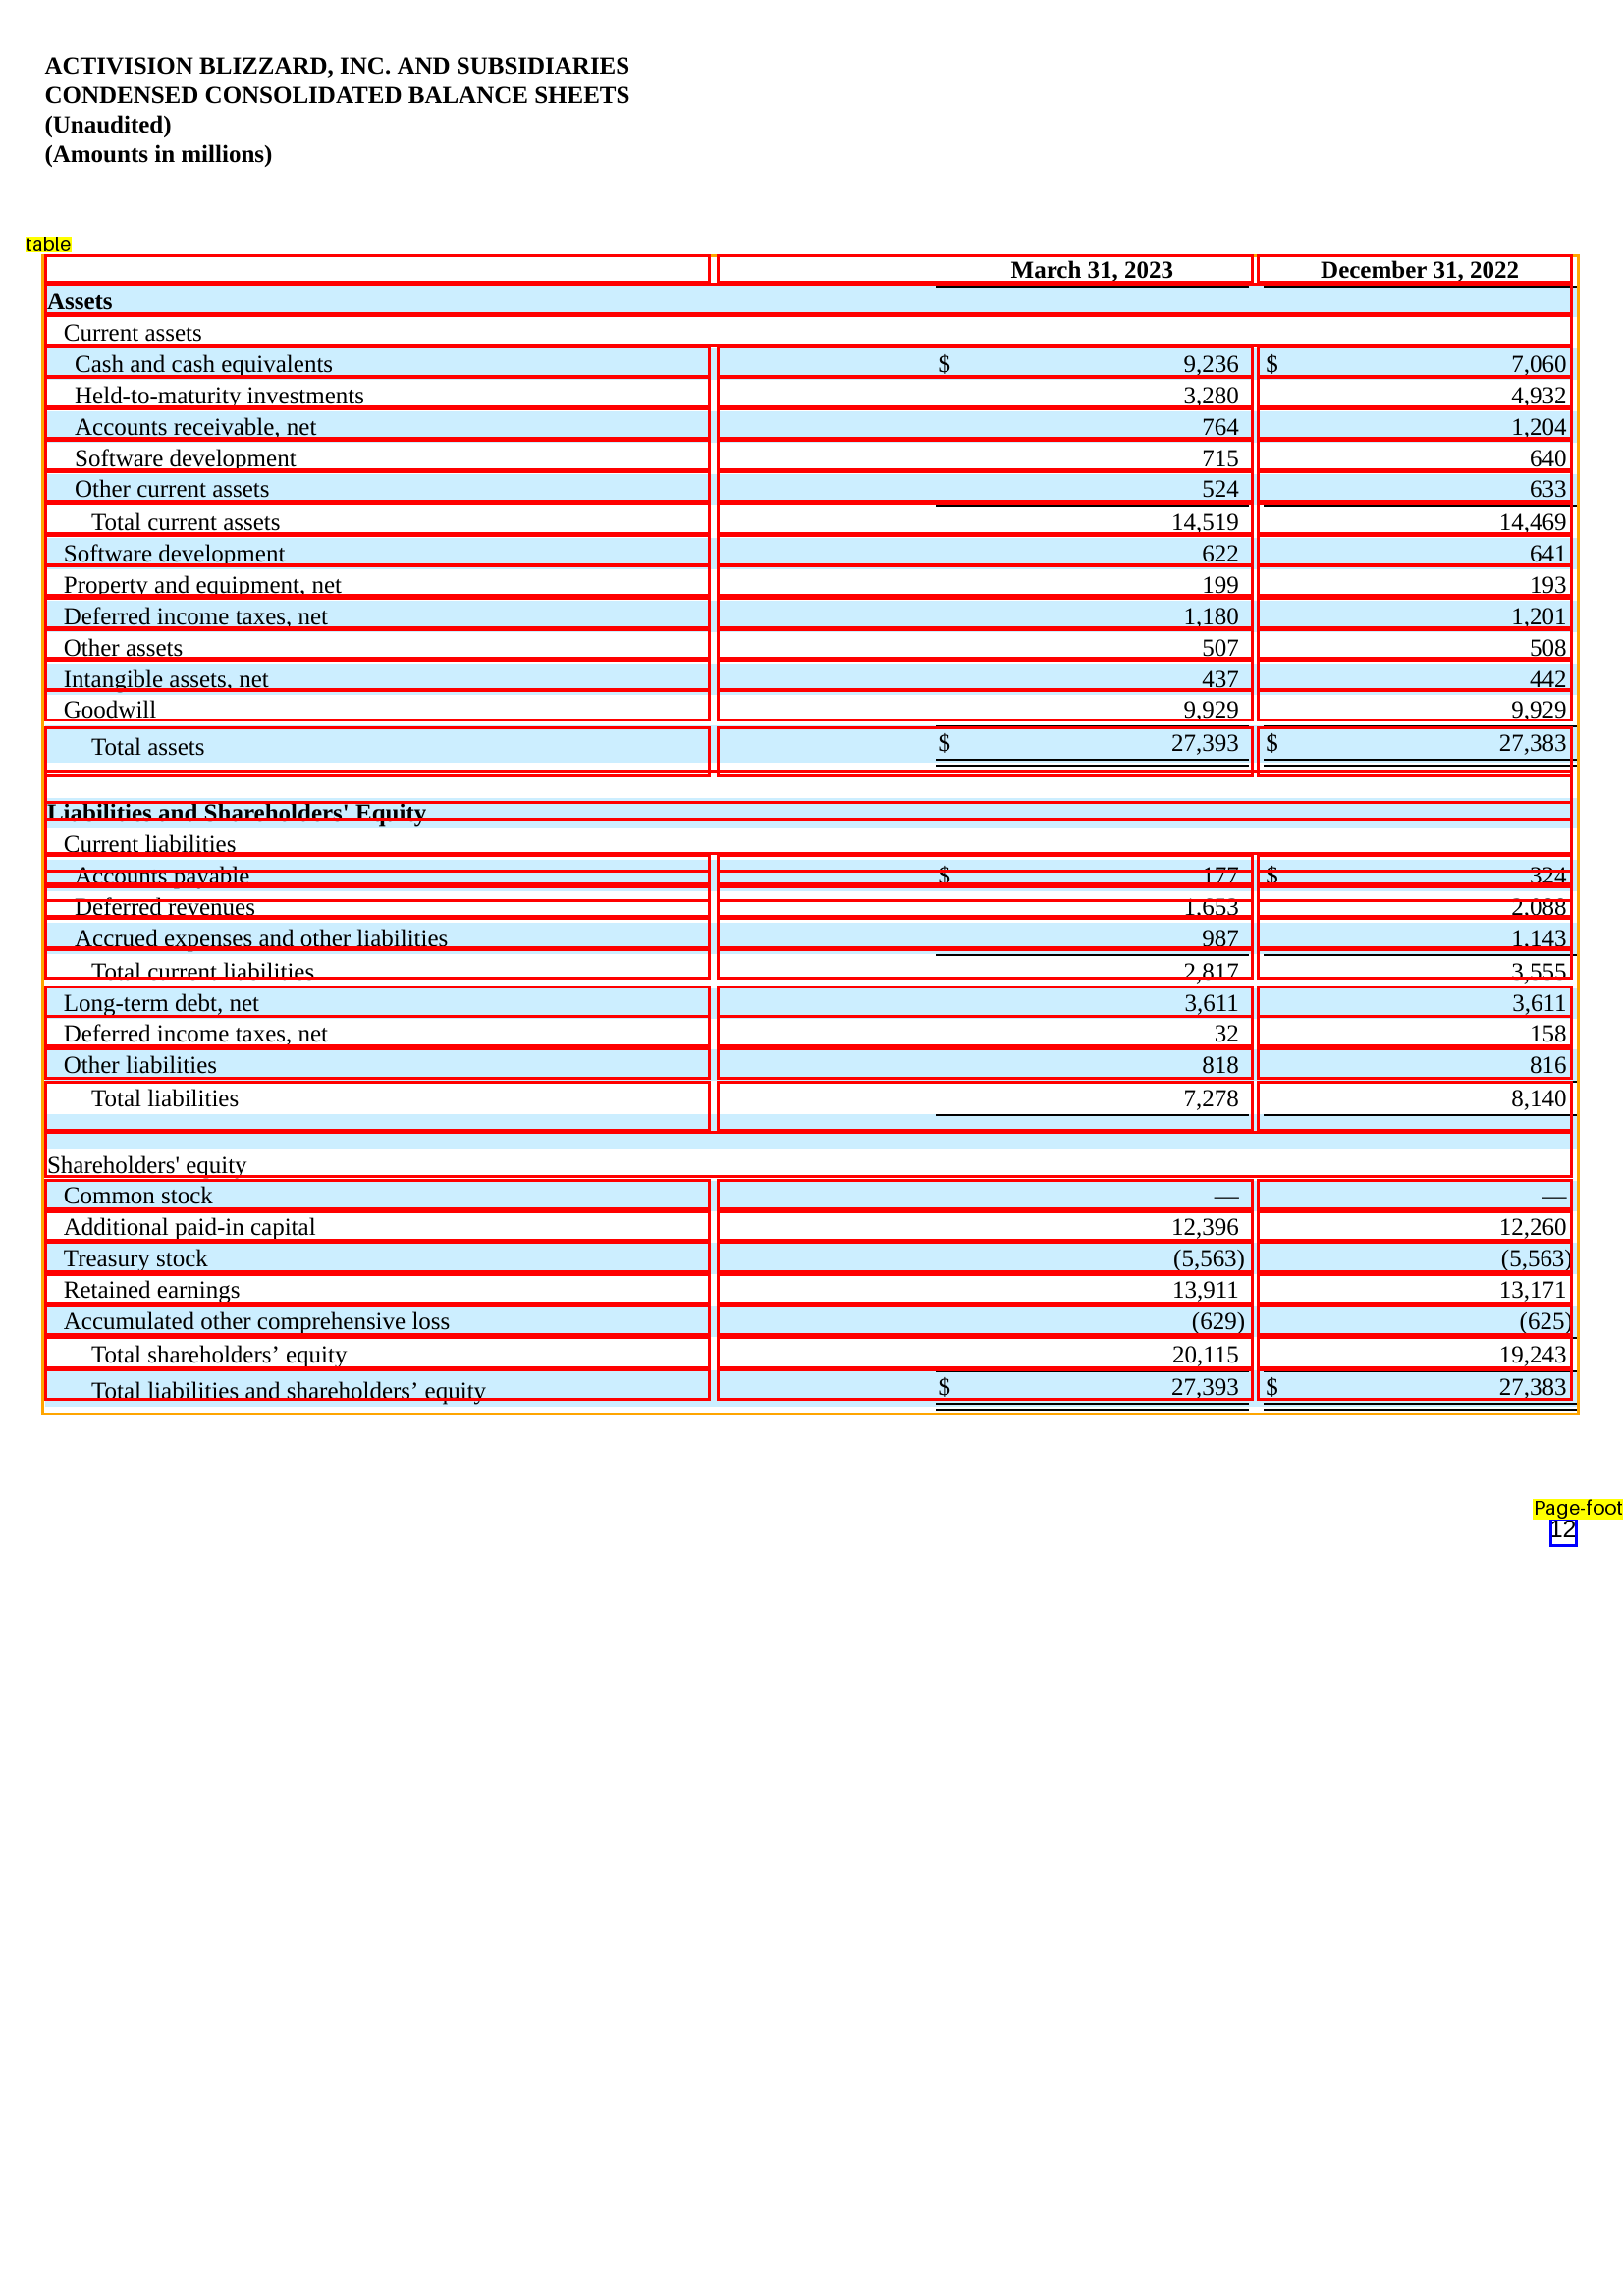

2024-07-10 22:26:39,124	WARNING util.py:560 -- The argument ``compute`` is deprecated in Ray 2.9. Please specify argument ``concurrency`` instead. For more information, see https://docs.ray.io/en/master/data/transforming-data.html#stateful-transforms.
2024-07-10 22:26:39,128	INFO streaming_executor.py:112 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-07-10_22-25-44_664218_148065/logs/ray-data
2024-07-10 22:26:39,128	INFO streaming_executor.py:113 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadBinary] -> TaskPoolMapOperator[Map(BinaryScan._to_document)] -> ActorPoolMapOperator[MapBatches(BaseMapTransformCallable___wrap)]


- ReadBinary->SplitBlocks(16) 1:   0%|          | 0/1 [00:00<?, ?it/s]

- Map(BinaryScan._to_document) 2:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(BaseMapTransformCallable___wrap) 3:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

[{'properties': {'path': '/home/admin/sycamore/examples/visualize_pdfs/actbl_1.pdf', 'filetype': 'application/pdf'}, 'elements': [{'type': 'table', 'bbox': (0.02582955288295665, 0.11100229538113911, 0.9731727410862825, 0.6162456432536607), 'properties': {'score': 0.9064463376998901, 'title': None, 'columns': None, 'rows': None, 'page_number': 1}, 'text_representation': "Assets\nCurrent assets\nCash and cash equivalents\nHeld-to-maturity investments\nAccounts receivable, net\nSoftware development\nOther current assets\nTotal current assets\nSoftware development\nProperty and equipment, net\nDeferred income taxes, net\nOther assets\nIntangible assets, net\nGoodwill\n\nTotal assets\n\nLiabilities and Shareholders' Equity\nCurrent liabilities\nAccounts payable\nDeferred revenues\nAccrued expenses and other liabilities\nTotal current liabilities\nLong-term debt, net\nDeferred income taxes, net\nOther liabilities\nTotal liabilities\n\nShareholders’ equity\nCommon stock\nAdditional paid-in ca

In [7]:
# Activision Blizzard
doc = partition_visualize("/home/admin/sycamore/examples/visualize_pdfs/actbl_1.pdf", True, 0.35)
doc

In [8]:
# for doc in docs[0].elements:
#     if doc.type == 'table':
#         table = doc.table

# table.cells

2024-07-10 22:26:52,235	WARNING util.py:560 -- The argument ``compute`` is deprecated in Ray 2.9. Please specify argument ``concurrency`` instead. For more information, see https://docs.ray.io/en/master/data/transforming-data.html#stateful-transforms.
2024-07-10 22:26:52,240	INFO streaming_executor.py:112 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-07-10_22-25-44_664218_148065/logs/ray-data
2024-07-10 22:26:52,241	INFO streaming_executor.py:113 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadBinary] -> TaskPoolMapOperator[Map(BinaryScan._to_document)] -> ActorPoolMapOperator[MapBatches(BaseMapTransformCallable___wrap)] -> TaskPoolMapOperator[MapBatches(split_and_convert_to_image)] -> LimitOperator[limit=1] -> TaskPoolMapOperator[MapBatches(DrawBoxes)]


- ReadBinary->SplitBlocks(16) 1:   0%|          | 0/1 [00:00<?, ?it/s]

- Map(BinaryScan._to_document) 2:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(BaseMapTransformCallable___wrap) 3:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(split_and_convert_to_image) 4:   0%|          | 0/1 [00:00<?, ?it/s]

- limit=1 5:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(DrawBoxes) 6:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

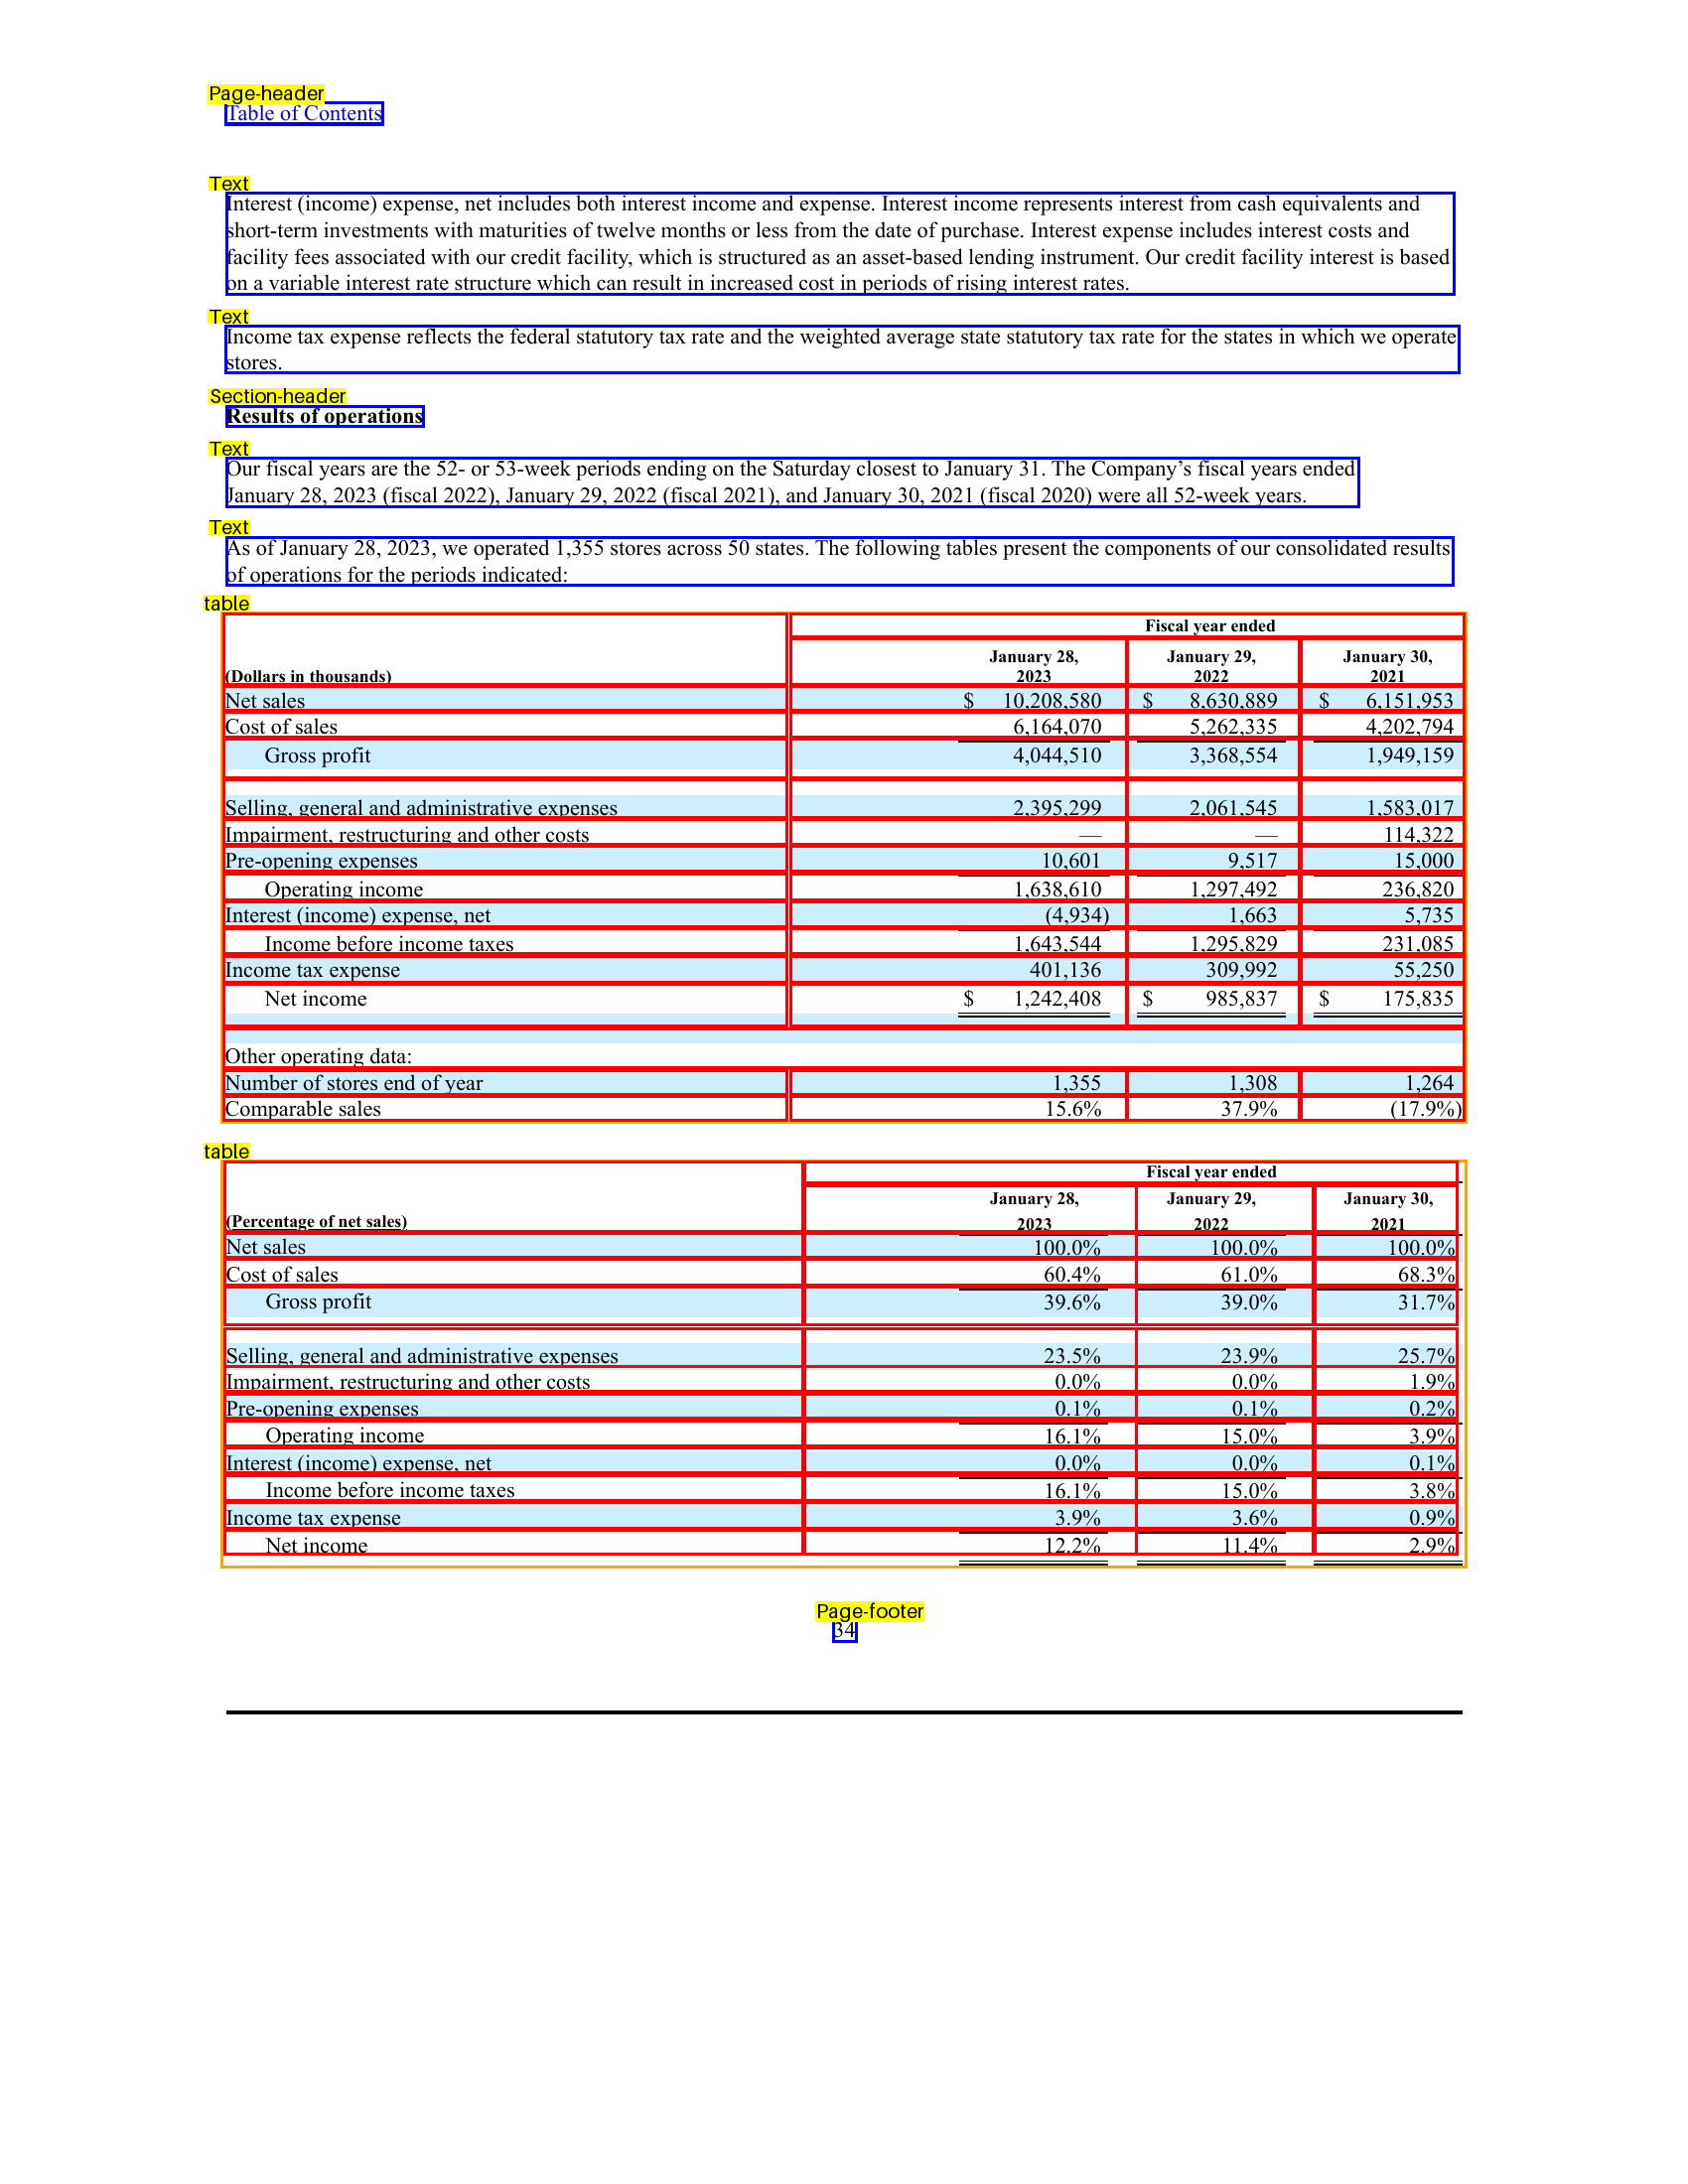

2024-07-10 22:27:06,342	WARNING util.py:560 -- The argument ``compute`` is deprecated in Ray 2.9. Please specify argument ``concurrency`` instead. For more information, see https://docs.ray.io/en/master/data/transforming-data.html#stateful-transforms.
2024-07-10 22:27:06,347	INFO streaming_executor.py:112 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-07-10_22-25-44_664218_148065/logs/ray-data
2024-07-10 22:27:06,347	INFO streaming_executor.py:113 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadBinary] -> TaskPoolMapOperator[Map(BinaryScan._to_document)] -> ActorPoolMapOperator[MapBatches(BaseMapTransformCallable___wrap)]


- ReadBinary->SplitBlocks(16) 1:   0%|          | 0/1 [00:00<?, ?it/s]

- Map(BinaryScan._to_document) 2:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(BaseMapTransformCallable___wrap) 3:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

[{'properties': {'path': '/home/admin/sycamore/examples/visualize_pdfs/ultabeauty_table.pdf', 'filetype': 'application/pdf'}, 'elements': [{'type': 'Page-header', 'bbox': (0.13335161994485295, 0.046735957752574574, 0.22736624325022978, 0.057378411726518114), 'properties': {'score': 0.653598427772522, 'page_number': 1}, 'text_representation': ''}, {'type': 'Text', 'bbox': (0.13375696518841912, 0.08800819396972656, 0.8618204273897059, 0.13503834117542612), 'properties': {'score': 0.9231100082397461, 'page_number': 1}, 'text_representation': 'Interest (income) expense, net includes both interest income and expense. Interest income represents interest from cash equivalents and\nshort-term investments with maturities of twelve months or less from the date of purchase. Interest expense includes interest costs and\nfacility fees associated with our credit facility, which is structured as an asset-based lending instrument. Our credit facility interest is based\non a variable interest rate stru

In [9]:
# ulta beauty table
partition_visualize("/home/admin/sycamore/examples/visualize_pdfs/ultabeauty_table.pdf", True, 0.35)

ERROR:root:Unable to load aryn config /home/admin/.aryn/config.yaml: [Errno 2] No such file or directory: '/home/admin/.aryn/config.yaml'
2024-07-09 21:16:32,081	WARNING util.py:560 -- The argument ``compute`` is deprecated in Ray 2.9. Please specify argument ``concurrency`` instead. For more information, see https://docs.ray.io/en/master/data/transforming-data.html#stateful-transforms.
2024-07-09 21:16:32,086	INFO streaming_executor.py:112 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-07-09_16-32-36_503269_2681/logs/ray-data
2024-07-09 21:16:32,087	INFO streaming_executor.py:113 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadBinary] -> TaskPoolMapOperator[Map(BinaryScan._to_document)] -> ActorPoolMapOperator[MapBatches(BaseMapTransformCallable___wrap)] -> TaskPoolMapOperator[MapBatches(split_and_convert_to_image)] -> LimitOperator[limit=1] -> TaskPoolMapOperator[MapBatches(DrawBoxes)]


- ReadBinary->SplitBlocks(16) 1:   0%|          | 0/1 [00:00<?, ?it/s]

- Map(BinaryScan._to_document) 2:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(BaseMapTransformCallable___wrap) 3:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(split_and_convert_to_image) 4:   0%|          | 0/1 [00:00<?, ?it/s]

- limit=1 5:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(DrawBoxes) 6:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

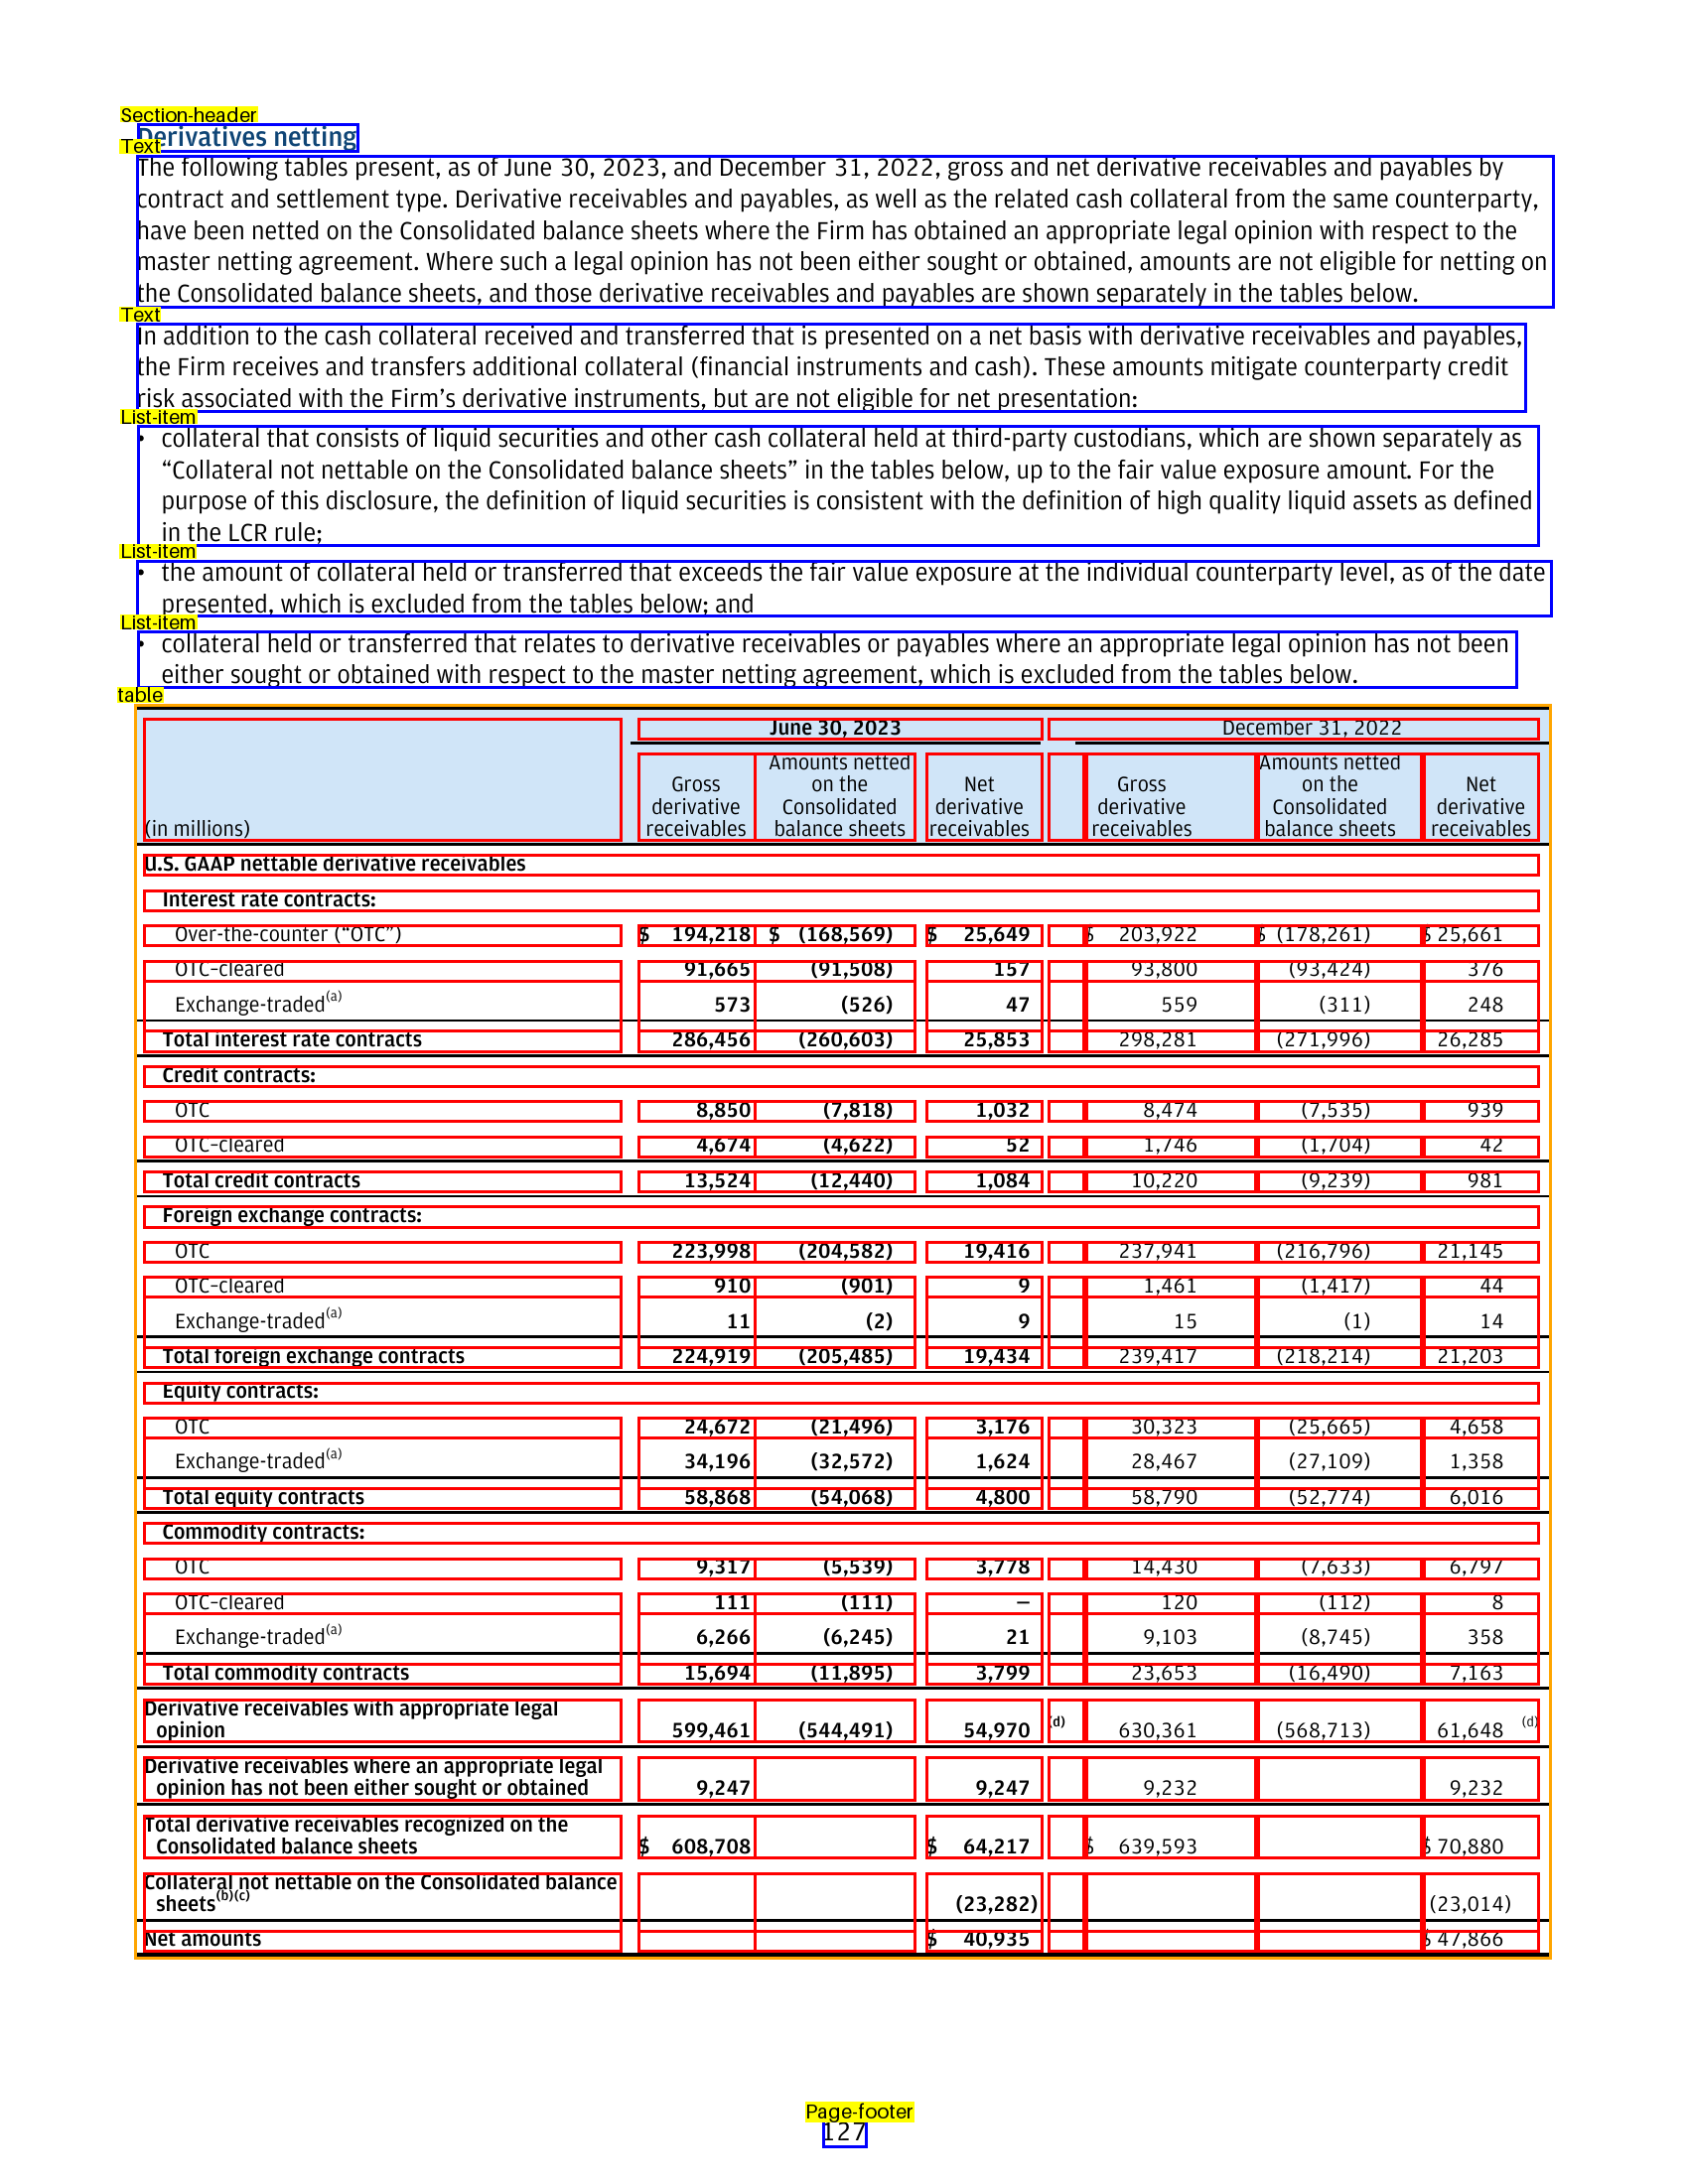

2024-07-09 21:16:39,598	WARNING util.py:560 -- The argument ``compute`` is deprecated in Ray 2.9. Please specify argument ``concurrency`` instead. For more information, see https://docs.ray.io/en/master/data/transforming-data.html#stateful-transforms.
2024-07-09 21:16:39,602	INFO streaming_executor.py:112 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-07-09_16-32-36_503269_2681/logs/ray-data
2024-07-09 21:16:39,602	INFO streaming_executor.py:113 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadBinary] -> TaskPoolMapOperator[Map(BinaryScan._to_document)] -> ActorPoolMapOperator[MapBatches(BaseMapTransformCallable___wrap)]


- ReadBinary->SplitBlocks(16) 1:   0%|          | 0/1 [00:00<?, ?it/s]

- Map(BinaryScan._to_document) 2:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(BaseMapTransformCallable___wrap) 3:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

{'properties': {'path': '/home/admin/sycamore/examples/visualize_pdfs/JPM_table.pdf',
                'filetype': 'application/pdf'},
 'elements': [{'type': 'Section-header',
               'bbox': (0.08126772712258731,
                        0.05678133184259588,
                        0.2124626787971048,
                        0.06968645962801846),
               'properties': {'score': 0.840736985206604, 'page_number': 1}},
              {'type': 'Text',
               'bbox': (0.08114484001608456,
                        0.07111093000932173,
                        0.9206279440487133,
                        0.140936279296875),
               'properties': {'score': 0.9211127758026123, 'page_number': 1},
               'text_representation': '9TaXePcXeTb(cid:1)(cid:64)TccX(cid:64)V\n'
                                      'N(cid:63)Y(cid:1)Zc(cid:67)(cid:67)ck(cid:64)b(cid:62)(cid:1 '
                                      '<1819 chars>'},
              {'type': 'Text',
          

KeyboardInterrupt: 

In [ ]:
# jpm table
partition_visualize("/home/admin/sycamore/examples/visualize_pdfs/JPM_table.pdf", True, 0.35)

ERROR:root:Unable to load aryn config /home/admin/.aryn/config.yaml: [Errno 2] No such file or directory: '/home/admin/.aryn/config.yaml'
2024-07-09 21:08:10,708	WARNING util.py:560 -- The argument ``compute`` is deprecated in Ray 2.9. Please specify argument ``concurrency`` instead. For more information, see https://docs.ray.io/en/master/data/transforming-data.html#stateful-transforms.
2024-07-09 21:08:10,713	INFO streaming_executor.py:112 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-07-09_16-32-36_503269_2681/logs/ray-data
2024-07-09 21:08:10,713	INFO streaming_executor.py:113 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadBinary] -> TaskPoolMapOperator[Map(BinaryScan._to_document)] -> ActorPoolMapOperator[MapBatches(BaseMapTransformCallable___wrap)] -> TaskPoolMapOperator[MapBatches(split_and_convert_to_image)] -> LimitOperator[limit=1] -> TaskPoolMapOperator[MapBatches(DrawBoxes)]


- ReadBinary->SplitBlocks(16) 1:   0%|          | 0/1 [00:00<?, ?it/s]

- Map(BinaryScan._to_document) 2:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(BaseMapTransformCallable___wrap) 3:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(split_and_convert_to_image) 4:   0%|          | 0/1 [00:00<?, ?it/s]

- limit=1 5:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(DrawBoxes) 6:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

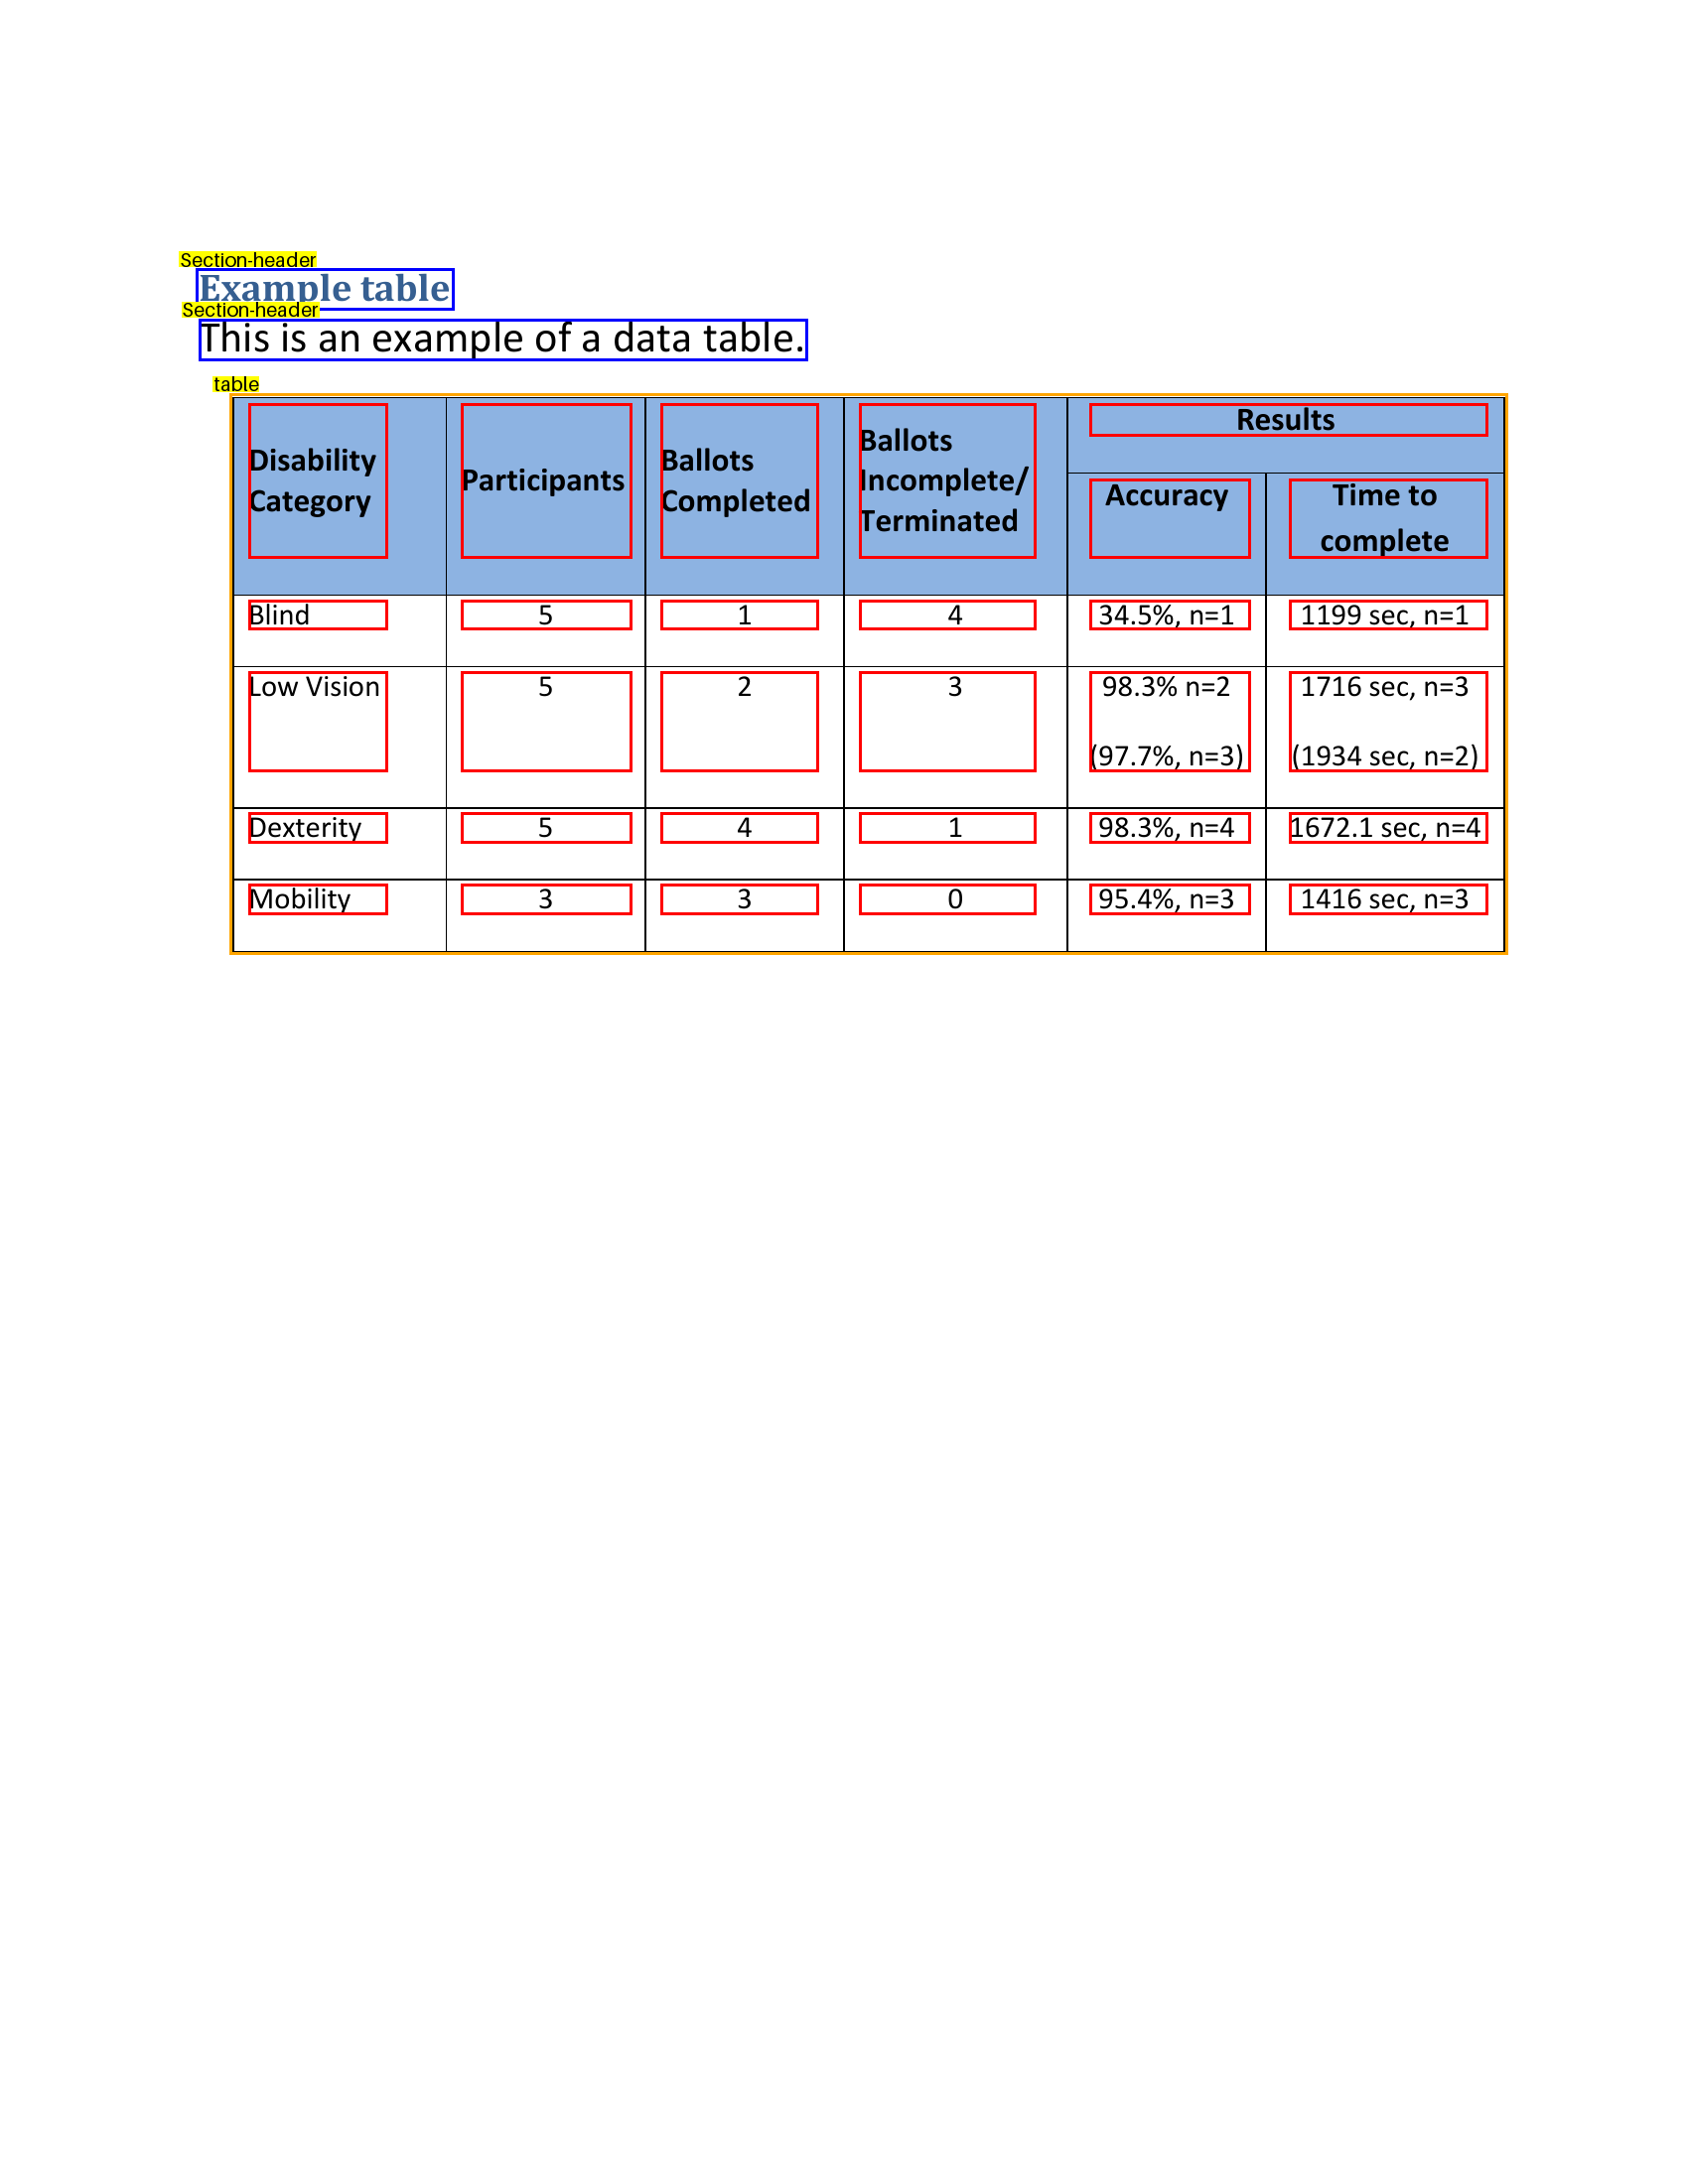

In [ ]:
# Page with table, 3M 10K
partition_visualize("/home/admin/sycamore/examples/visualize_pdfs/table-2.pdf", True, 0.35)

2024-06-12 19:33:38,625	INFO streaming_executor.py:115 -- Starting execution of Dataset. Full log is in /tmp/ray/session_2024-06-12_16-21-46_510622_17252/logs/ray-data.log
2024-06-12 19:33:38,625	INFO streaming_executor.py:116 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadBinary] -> TaskPoolMapOperator[Map(BinaryScan._to_document)->MapBatches(_wrap)->MapBatches(split_and_convert_to_image)] -> LimitOperator[limit=1] -> TaskPoolMapOperator[MapBatches(DrawBoxes)] -> LimitOperator[limit=1]



- ReadBinary->SplitBlocks(20) 1:   0%|          | 0/1 [00:00<?, ?it/s]

- Map(BinaryScan._to_document)->MapBatches(_wrap)->MapBatches(split_and_convert_to_image) 2:   0%|          | …

- limit=1 3:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(DrawBoxes) 4:   0%|          | 0/1 [00:00<?, ?it/s]

- limit=1 5:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

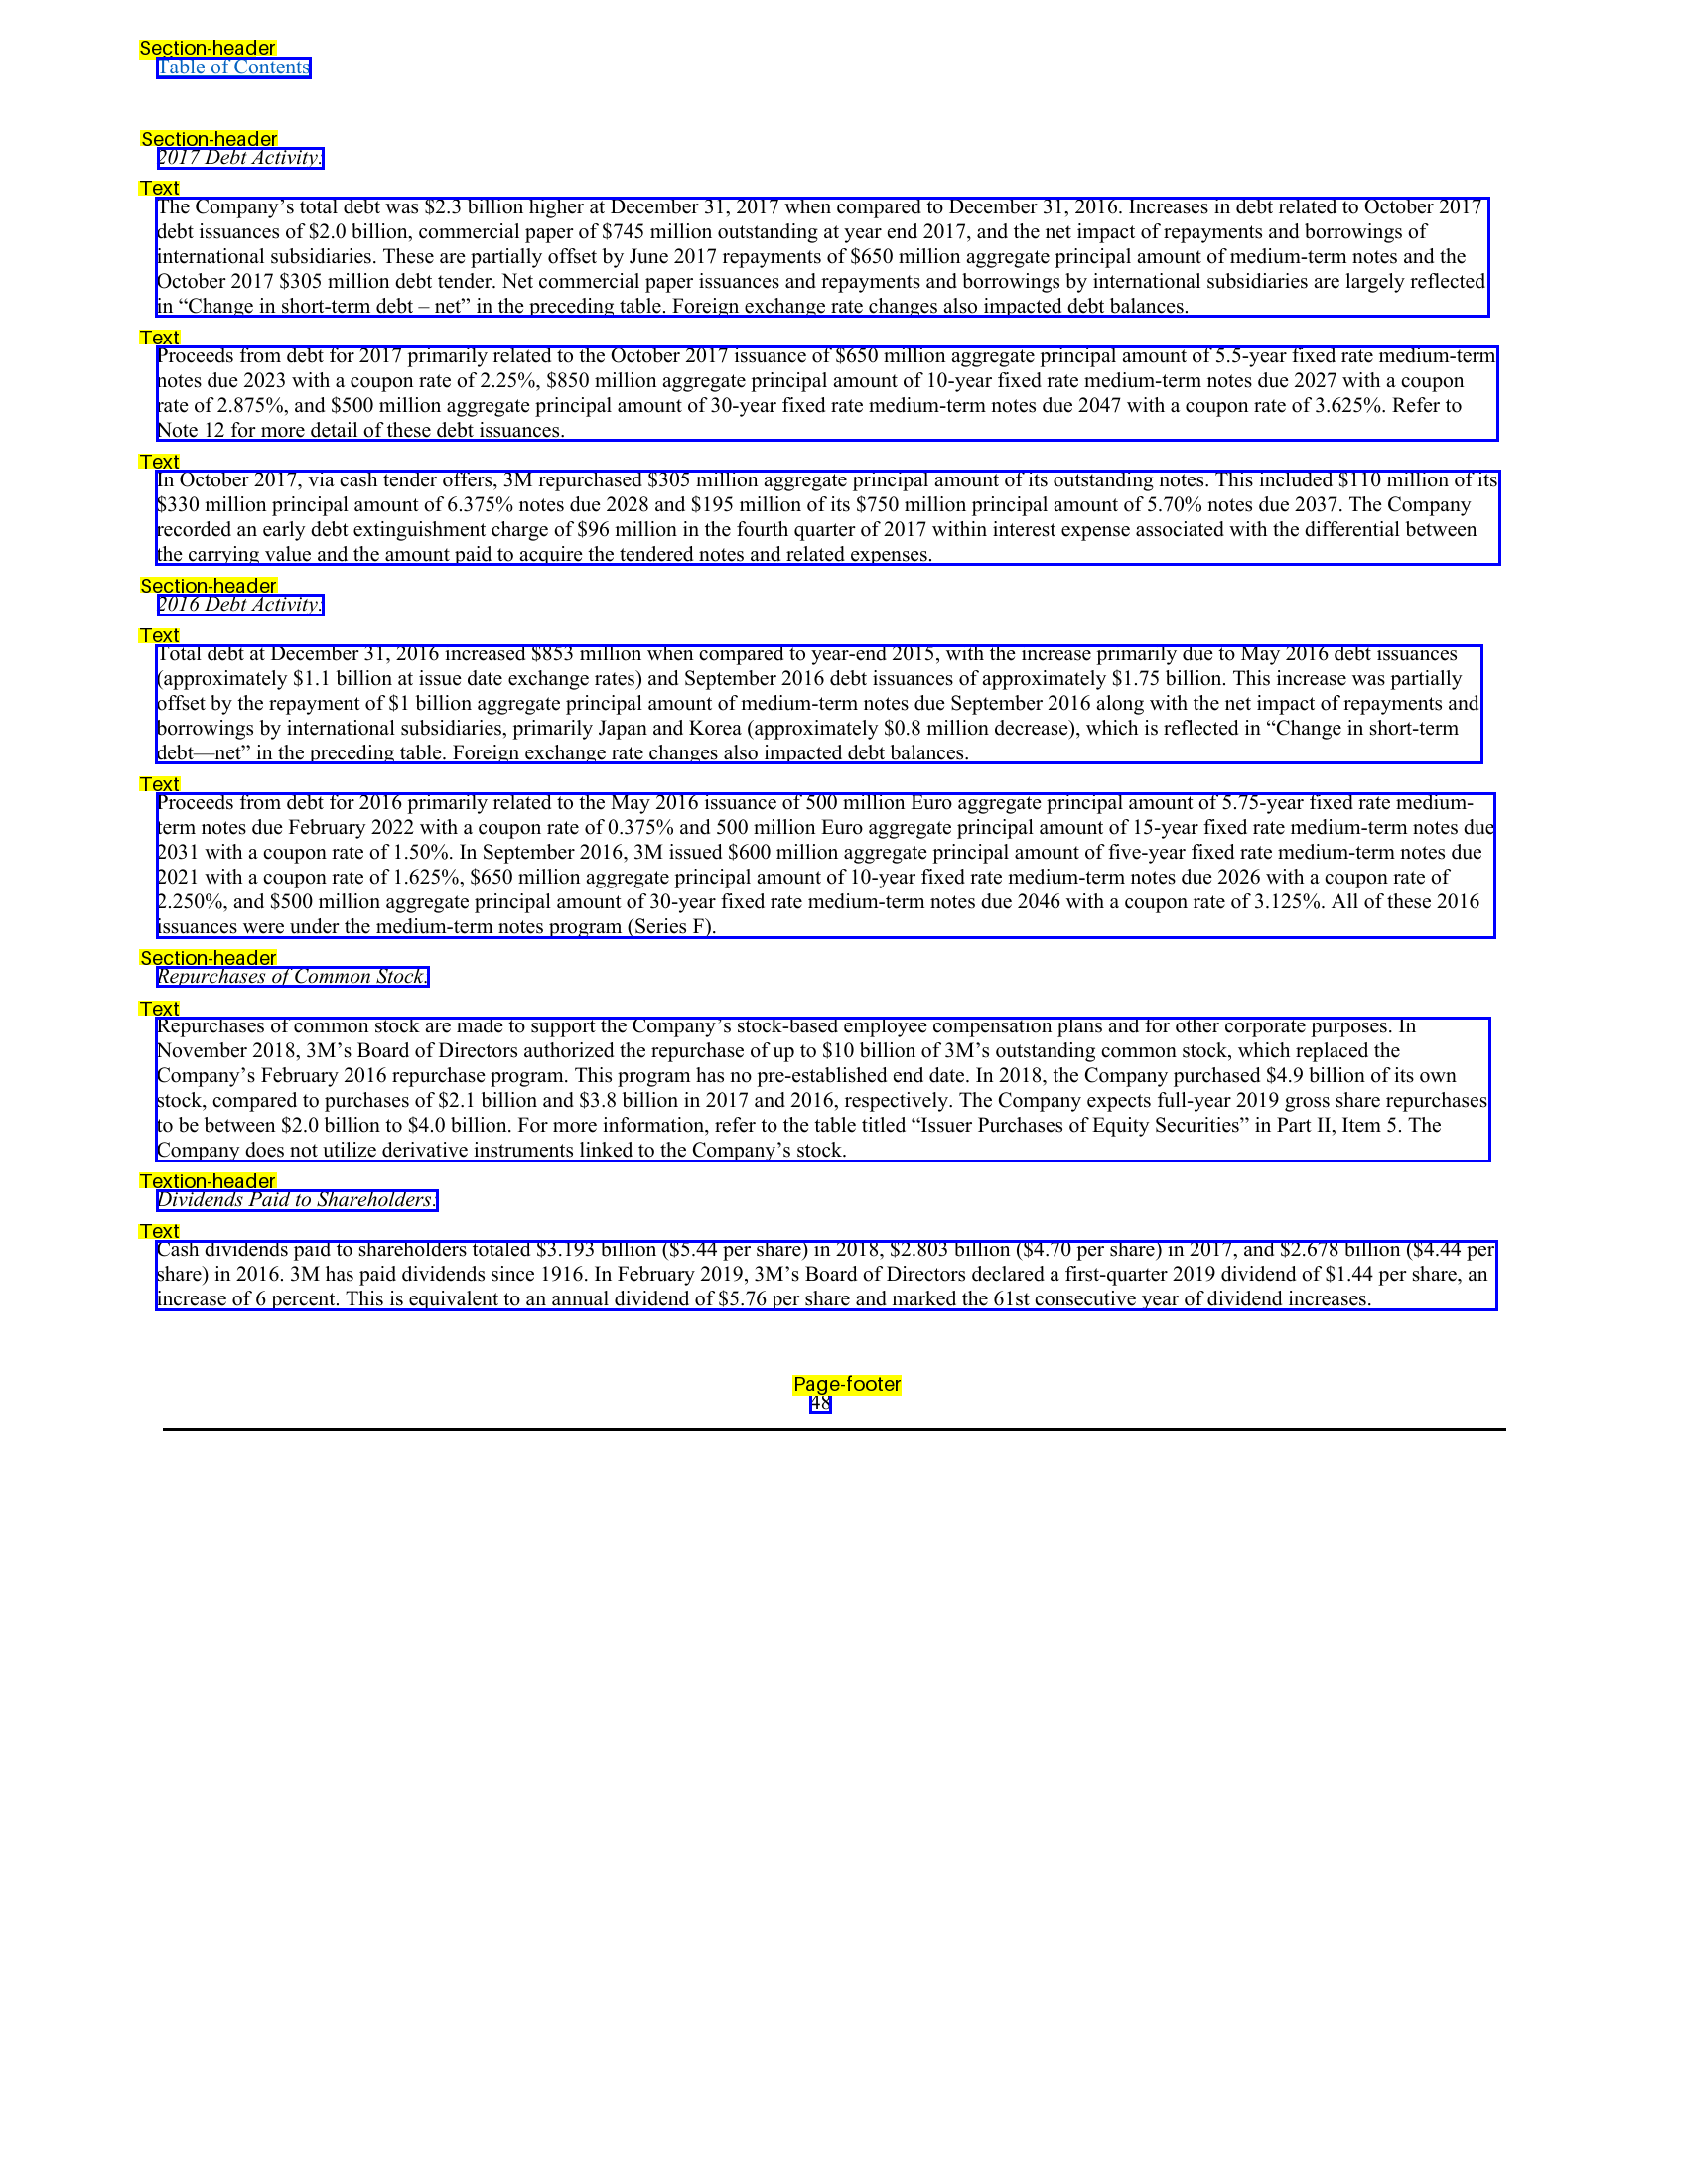

In [ ]:
# Page with text, 3M 10K
partition_visualize("/app/work/docker_volume/visualize_pdfs/3m_text.pdf", False, 0.3)

2024-06-12 19:34:03,515	INFO streaming_executor.py:115 -- Starting execution of Dataset. Full log is in /tmp/ray/session_2024-06-12_16-21-46_510622_17252/logs/ray-data.log
2024-06-12 19:34:03,516	INFO streaming_executor.py:116 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadBinary] -> TaskPoolMapOperator[Map(BinaryScan._to_document)->MapBatches(_wrap)->MapBatches(split_and_convert_to_image)] -> LimitOperator[limit=1] -> TaskPoolMapOperator[MapBatches(DrawBoxes)] -> LimitOperator[limit=1]



- ReadBinary->SplitBlocks(20) 1:   0%|          | 0/1 [00:00<?, ?it/s]

- Map(BinaryScan._to_document)->MapBatches(_wrap)->MapBatches(split_and_convert_to_image) 2:   0%|          | …

- limit=1 3:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(DrawBoxes) 4:   0%|          | 0/1 [00:00<?, ?it/s]

- limit=1 5:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

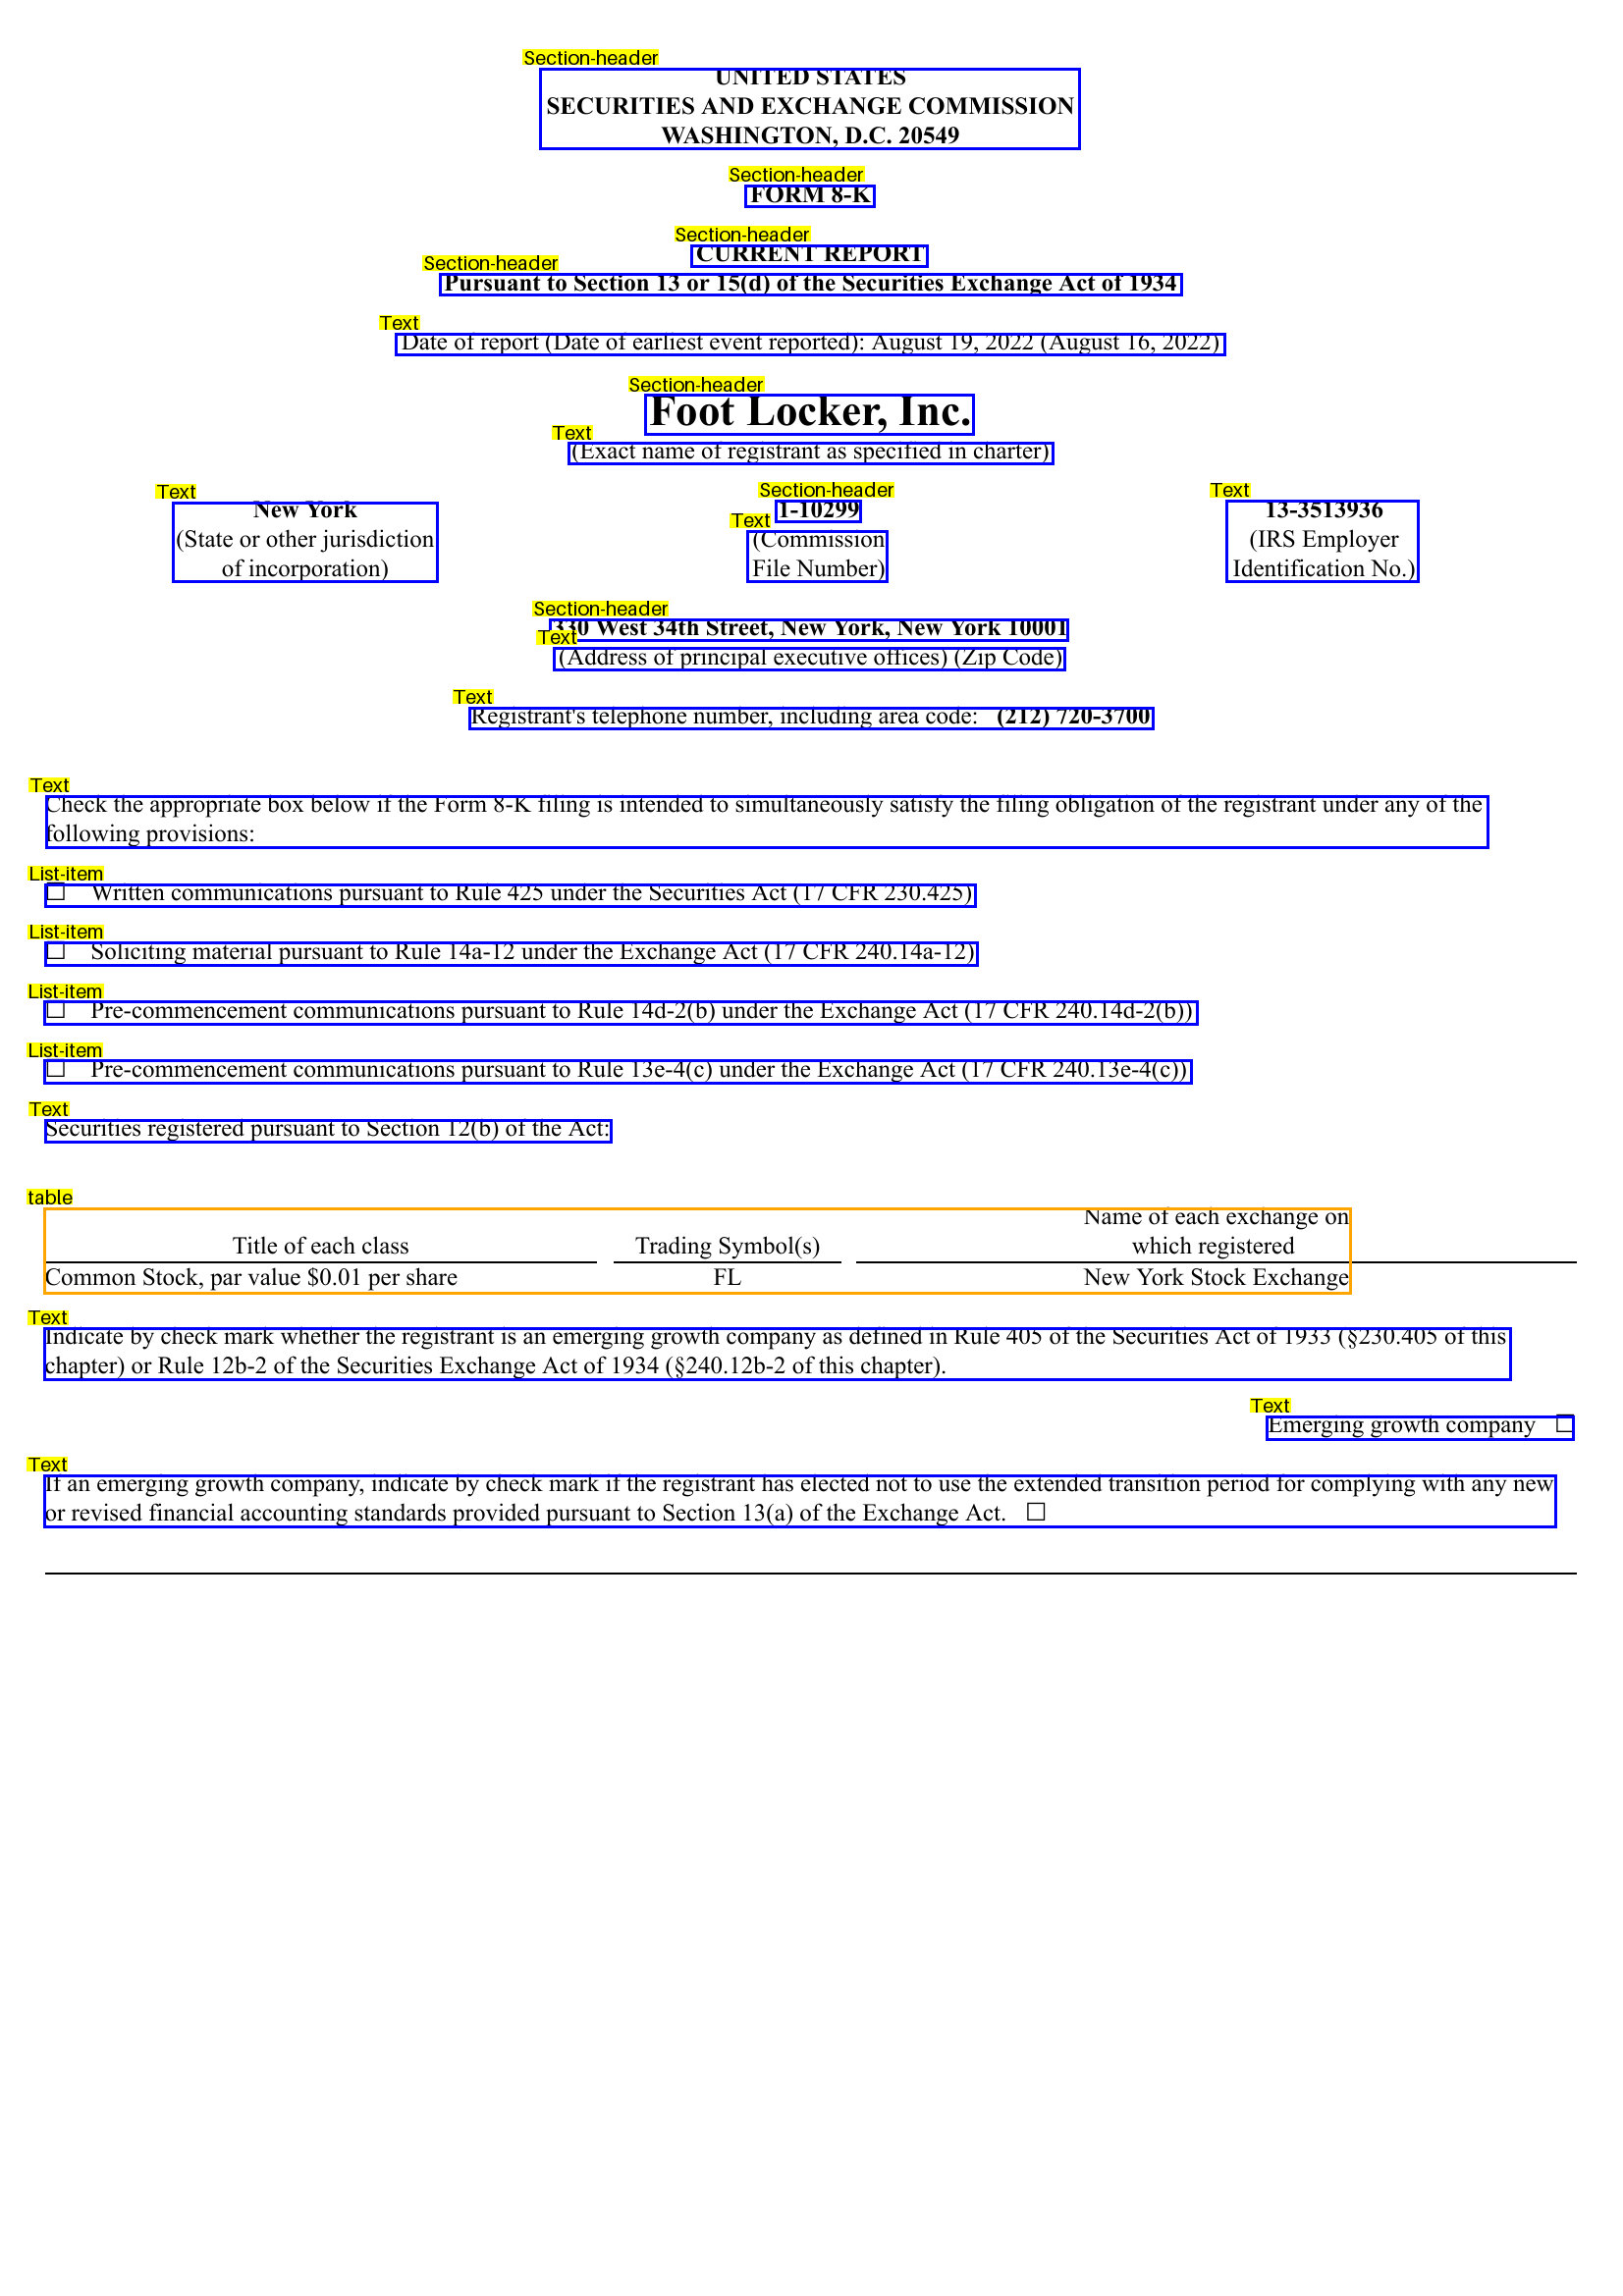

In [ ]:
# Title page, Foot Locker 8K
partition_visualize("/app/work/docker_volume/visualize_pdfs/footlocker_title.pdf", False, 0.35)

2024-06-12 19:34:26,106	INFO streaming_executor.py:115 -- Starting execution of Dataset. Full log is in /tmp/ray/session_2024-06-12_16-21-46_510622_17252/logs/ray-data.log
2024-06-12 19:34:26,107	INFO streaming_executor.py:116 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadBinary] -> TaskPoolMapOperator[Map(BinaryScan._to_document)->MapBatches(_wrap)->MapBatches(split_and_convert_to_image)] -> LimitOperator[limit=1] -> TaskPoolMapOperator[MapBatches(DrawBoxes)] -> LimitOperator[limit=1]



- ReadBinary->SplitBlocks(20) 1:   0%|          | 0/1 [00:00<?, ?it/s]

- Map(BinaryScan._to_document)->MapBatches(_wrap)->MapBatches(split_and_convert_to_image) 2:   0%|          | …

- limit=1 3:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(DrawBoxes) 4:   0%|          | 0/1 [00:00<?, ?it/s]

- limit=1 5:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

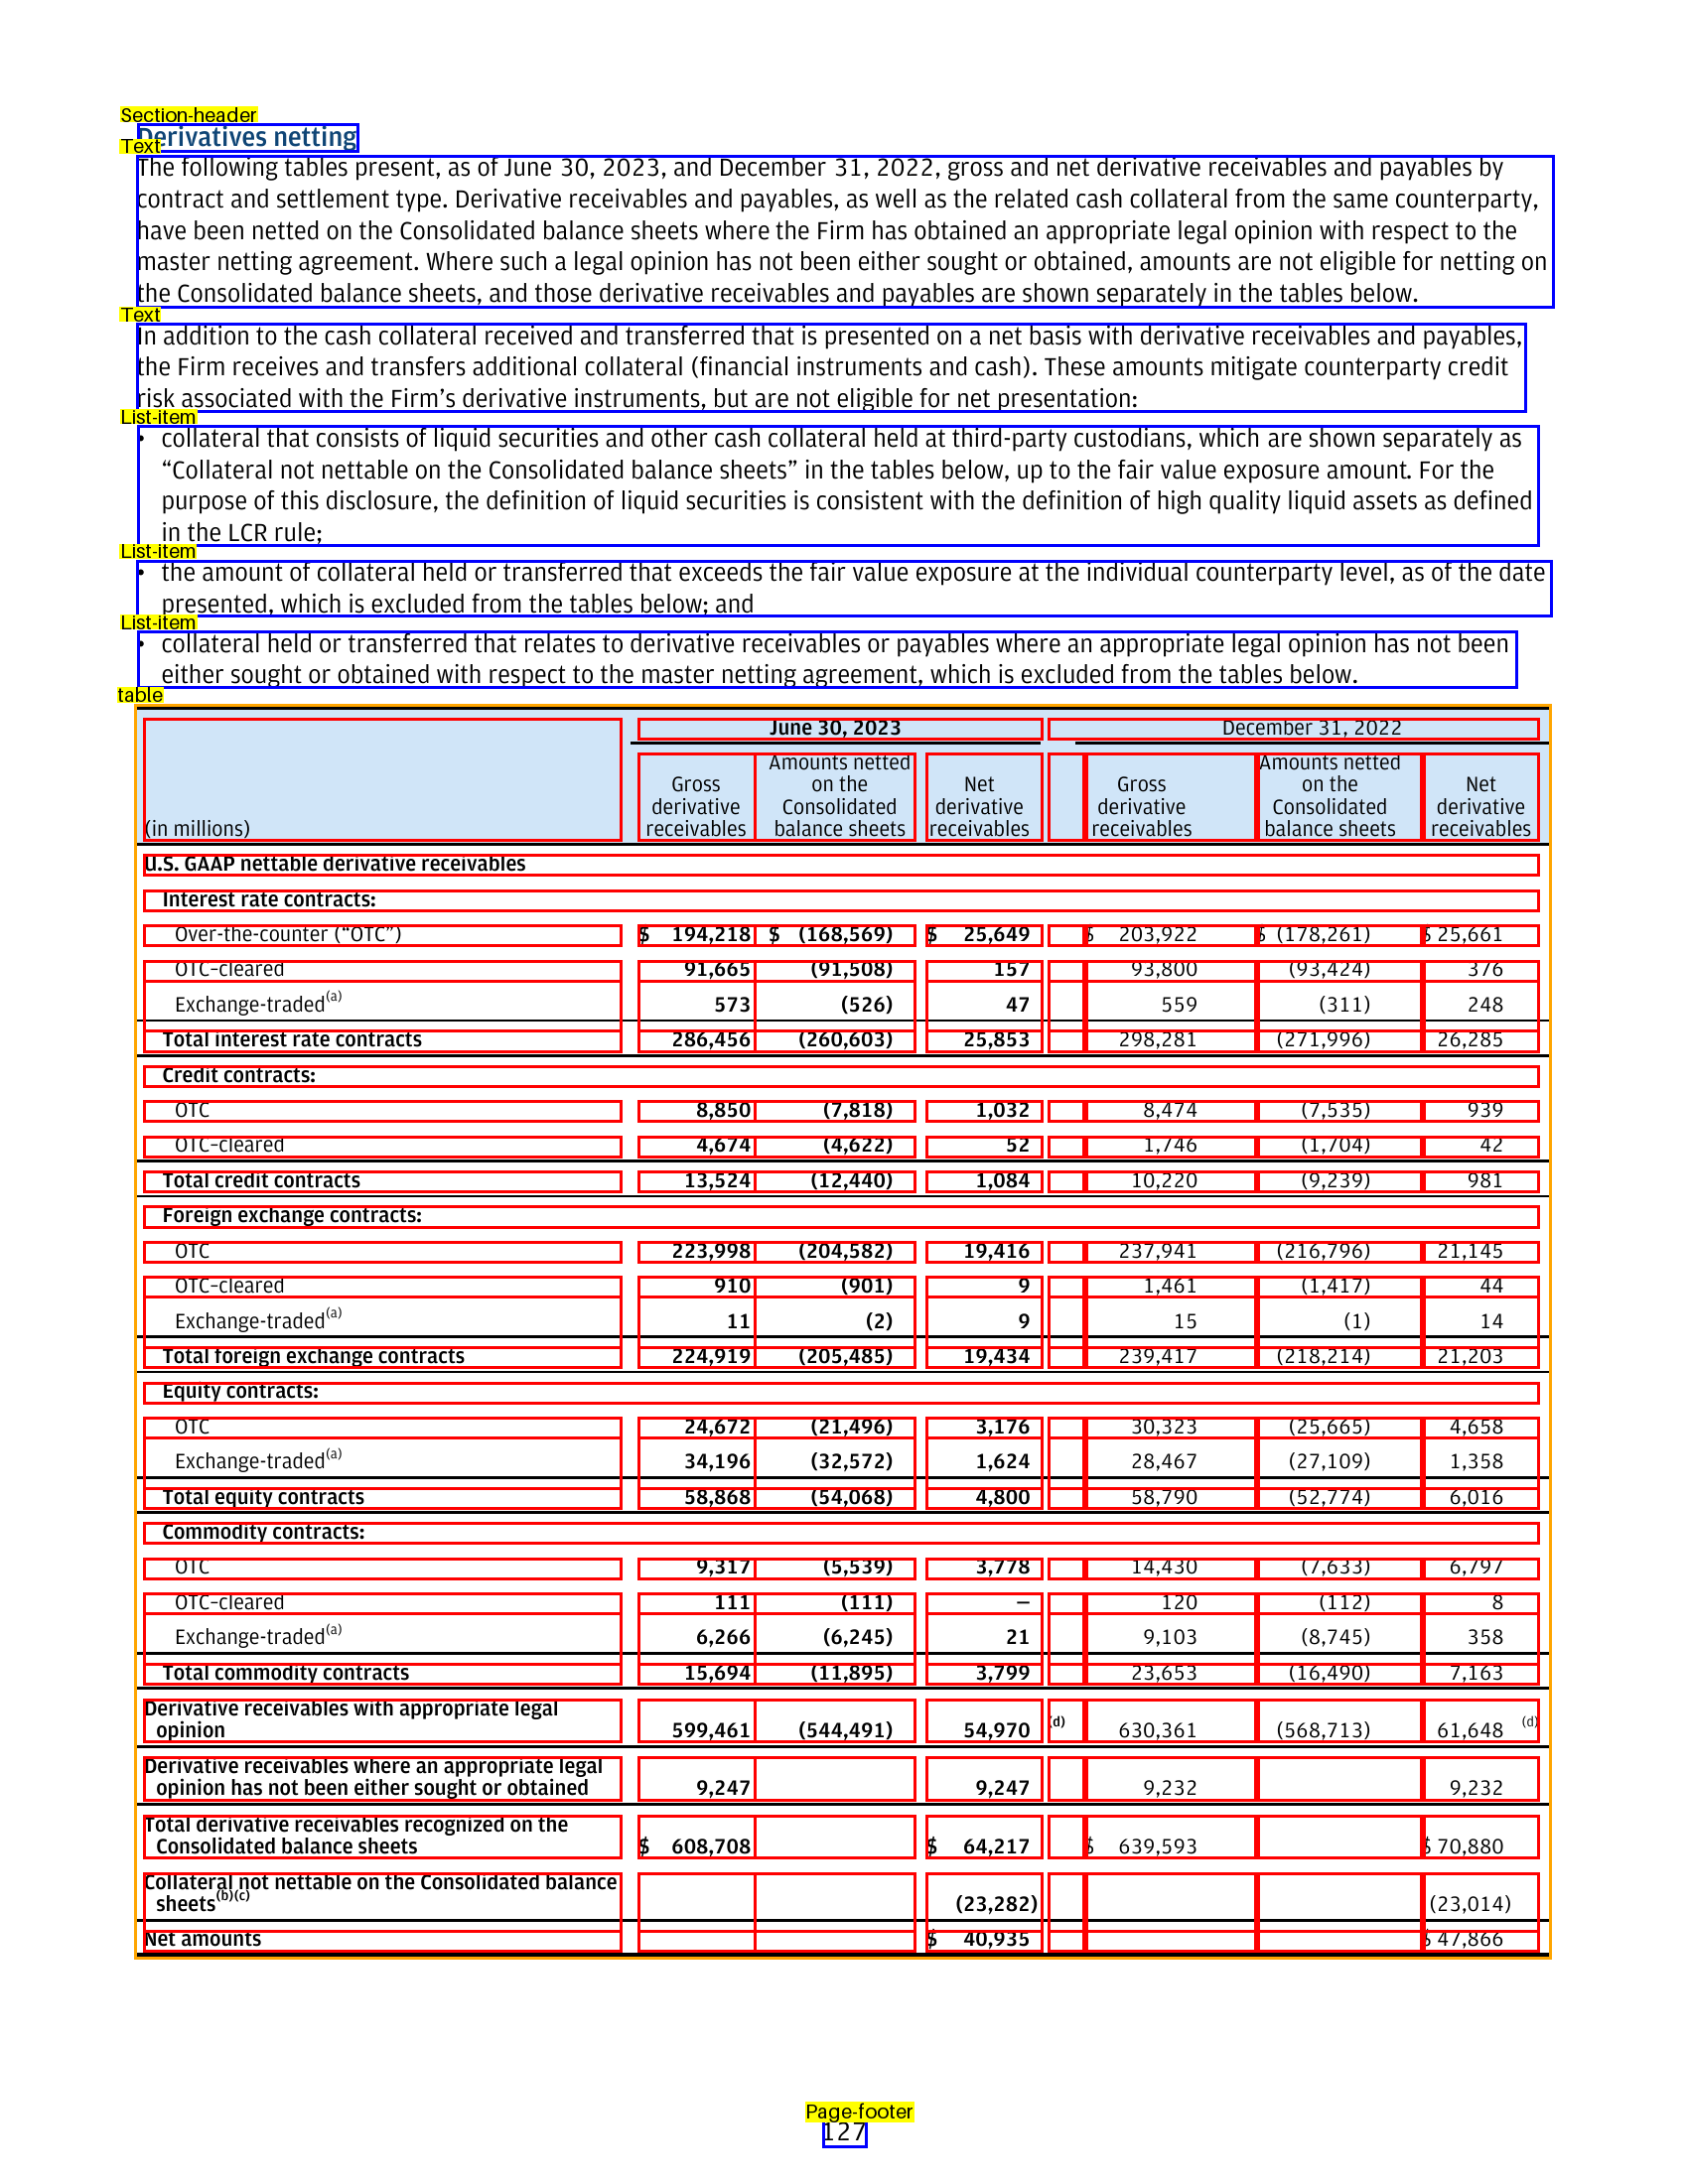

In [ ]:
# Page with table, JP Morgan 10Q
partition_visualize("/app/work/docker_volume/visualize_pdfs/JPM_table.pdf", True, 0.35)

2024-06-12 19:55:10,150	WARNING util.py:561 -- The argument ``compute`` is deprecated in Ray 2.9. Please specify argument ``concurrency`` instead. For more information, see https://docs.ray.io/en/master/data/transforming-data.html#stateful-transforms.
2024-06-12 19:55:10,162	INFO streaming_executor.py:115 -- Starting execution of Dataset. Full log is in /tmp/ray/session_2024-06-12_16-21-46_510622_17252/logs/ray-data.log
2024-06-12 19:55:10,163	INFO streaming_executor.py:116 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadBinary] -> ActorPoolMapOperator[Map(BinaryScan._to_document)->MapBatches(BaseMapTransformCallable___wrap)] -> TaskPoolMapOperator[MapBatches(split_and_convert_to_image)] -> LimitOperator[limit=1] -> TaskPoolMapOperator[MapBatches(DrawBoxes)] -> LimitOperator[limit=1]



- ReadBinary->SplitBlocks(20) 1:   0%|          | 0/1 [00:00<?, ?it/s]

- Map(BinaryScan._to_document)->MapBatches(BaseMapTransformCallable___wrap) 2:   0%|          | 0/1 [00:00<?, …

- MapBatches(split_and_convert_to_image) 3:   0%|          | 0/1 [00:00<?, ?it/s]

- limit=1 4:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(DrawBoxes) 5:   0%|          | 0/1 [00:00<?, ?it/s]

- limit=1 6:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

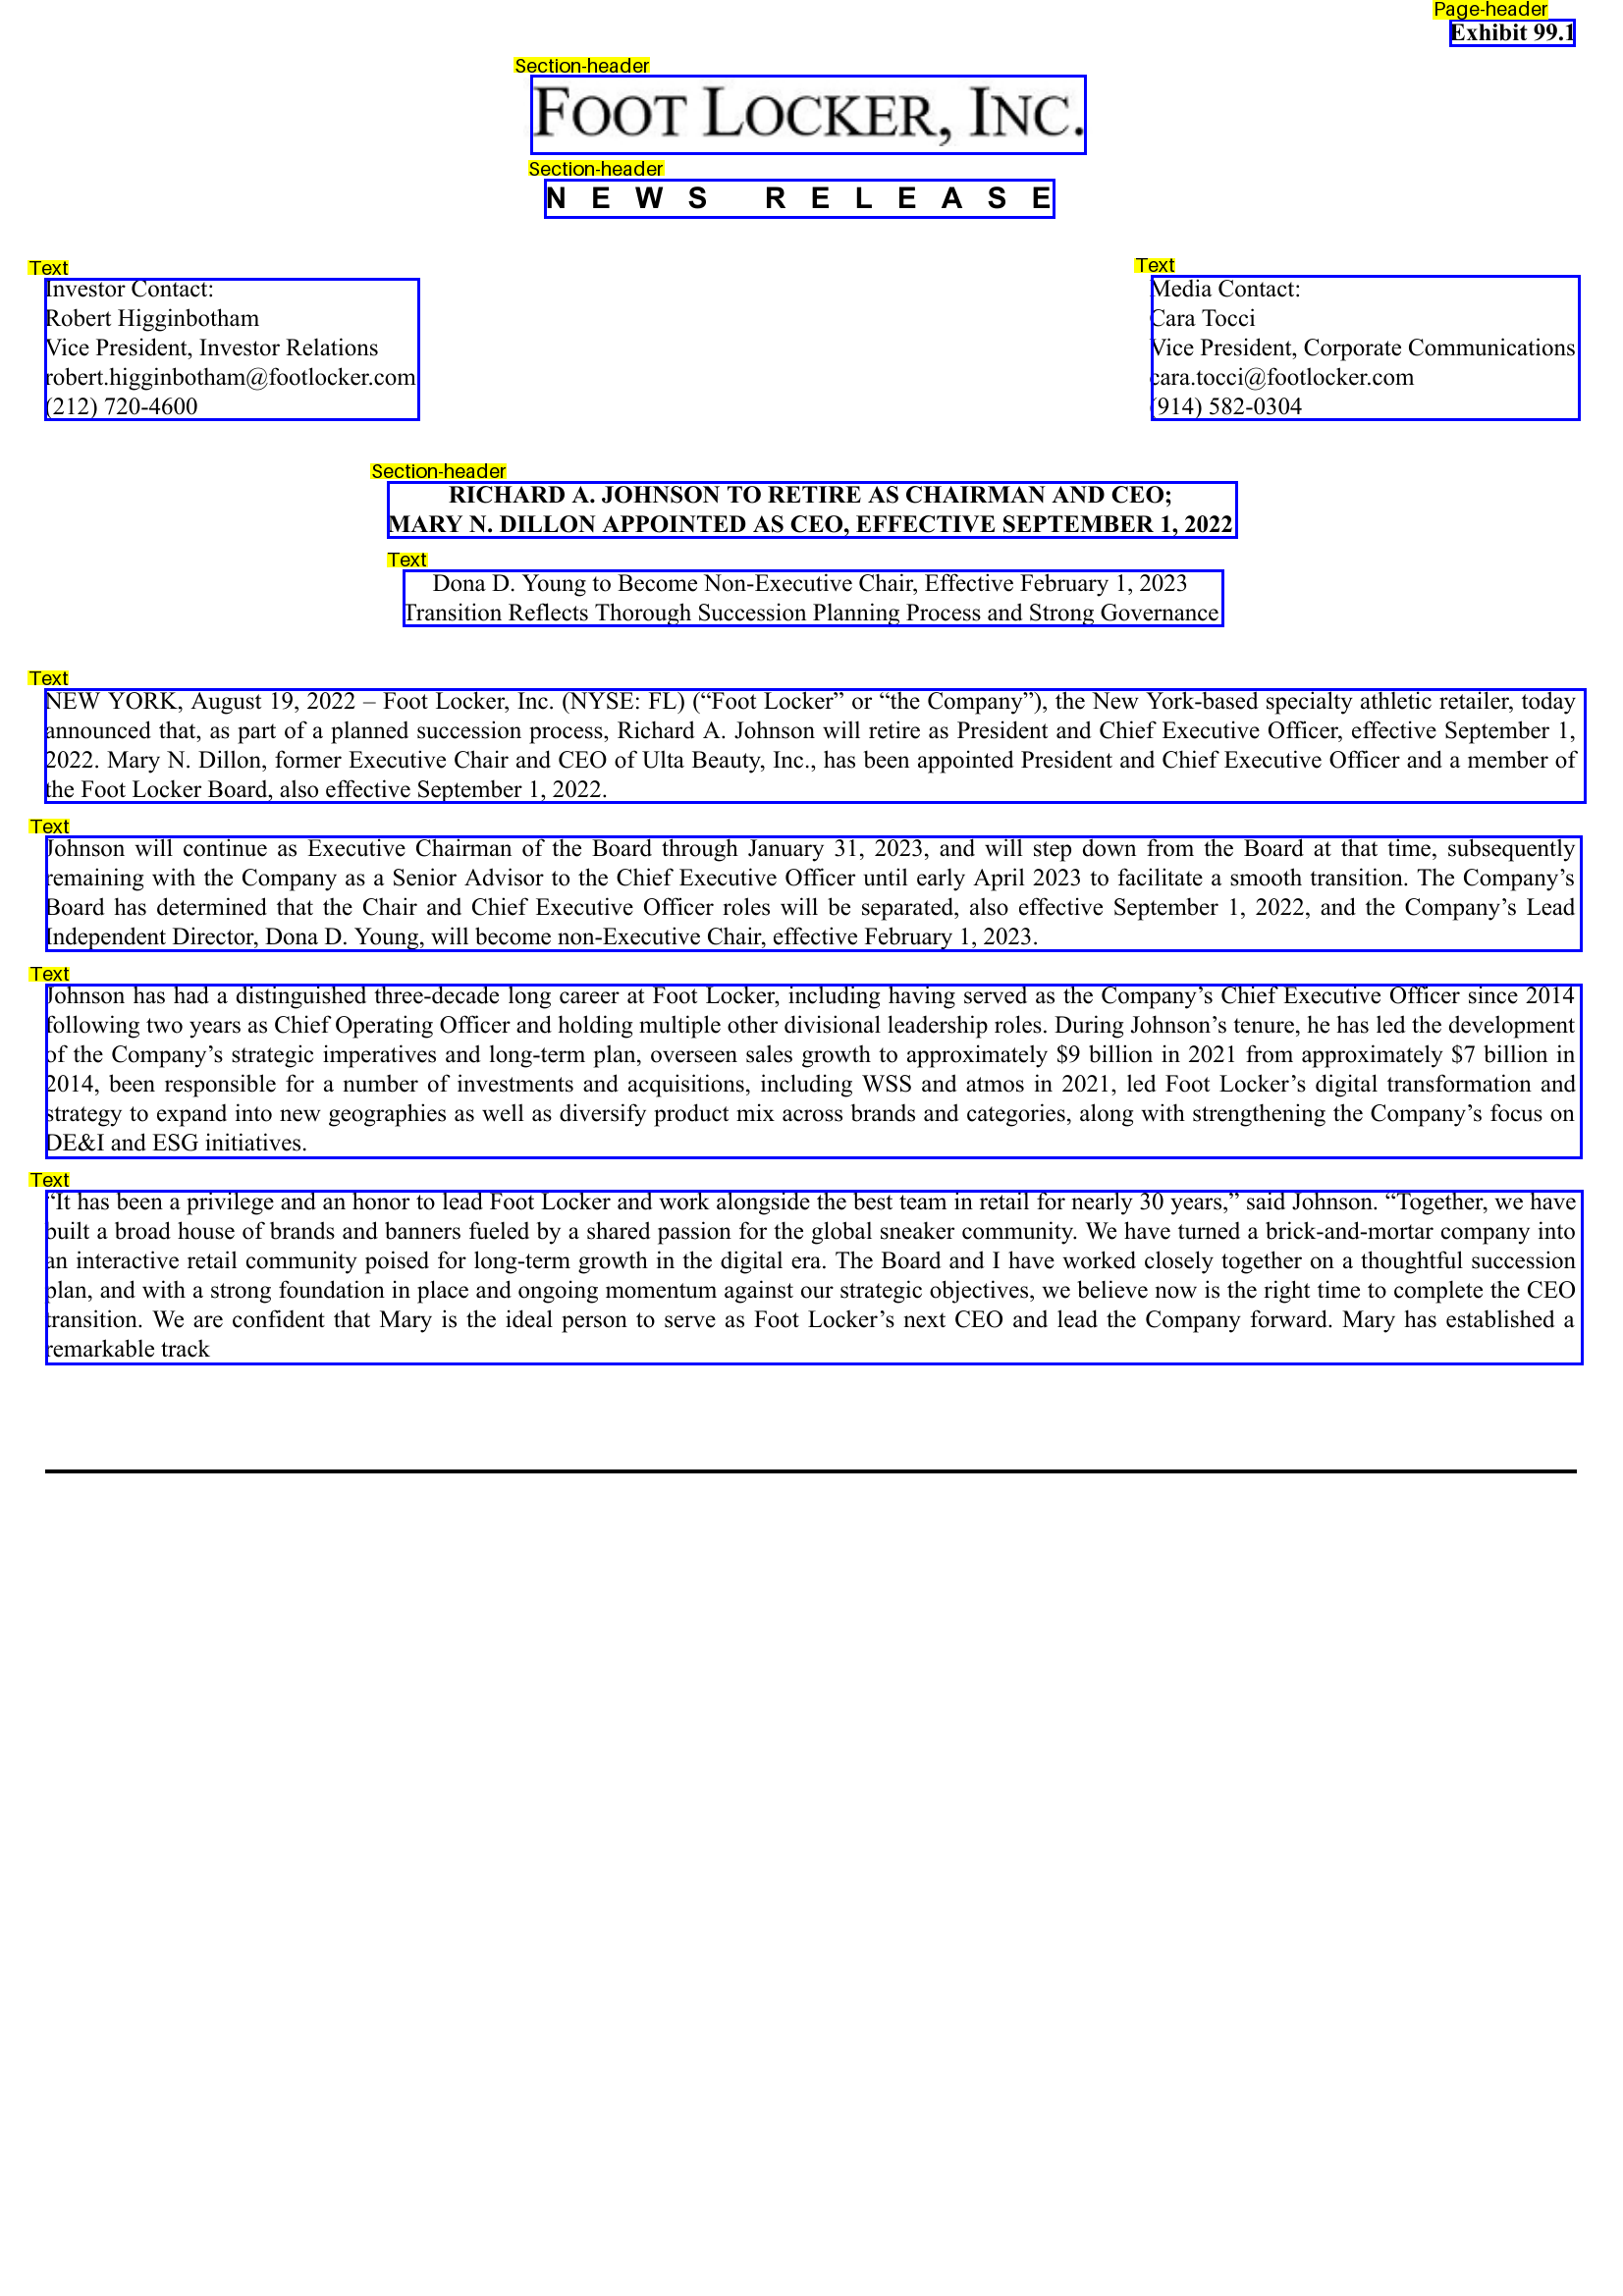

In [ ]:
# Page with text, Foot Locker 8K
partition_visualize("/app/work/docker_volume/visualize_pdfs/footlocker_text.pdf", False)

2024-06-12 19:36:46,771	INFO streaming_executor.py:115 -- Starting execution of Dataset. Full log is in /tmp/ray/session_2024-06-12_16-21-46_510622_17252/logs/ray-data.log
2024-06-12 19:36:46,772	INFO streaming_executor.py:116 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadBinary] -> TaskPoolMapOperator[Map(BinaryScan._to_document)->MapBatches(_wrap)->MapBatches(split_and_convert_to_image)] -> LimitOperator[limit=1] -> TaskPoolMapOperator[MapBatches(DrawBoxes)] -> LimitOperator[limit=1]



- ReadBinary->SplitBlocks(20) 1:   0%|          | 0/1 [00:00<?, ?it/s]

- Map(BinaryScan._to_document)->MapBatches(_wrap)->MapBatches(split_and_convert_to_image) 2:   0%|          | …

- limit=1 3:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(DrawBoxes) 4:   0%|          | 0/1 [00:00<?, ?it/s]

- limit=1 5:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

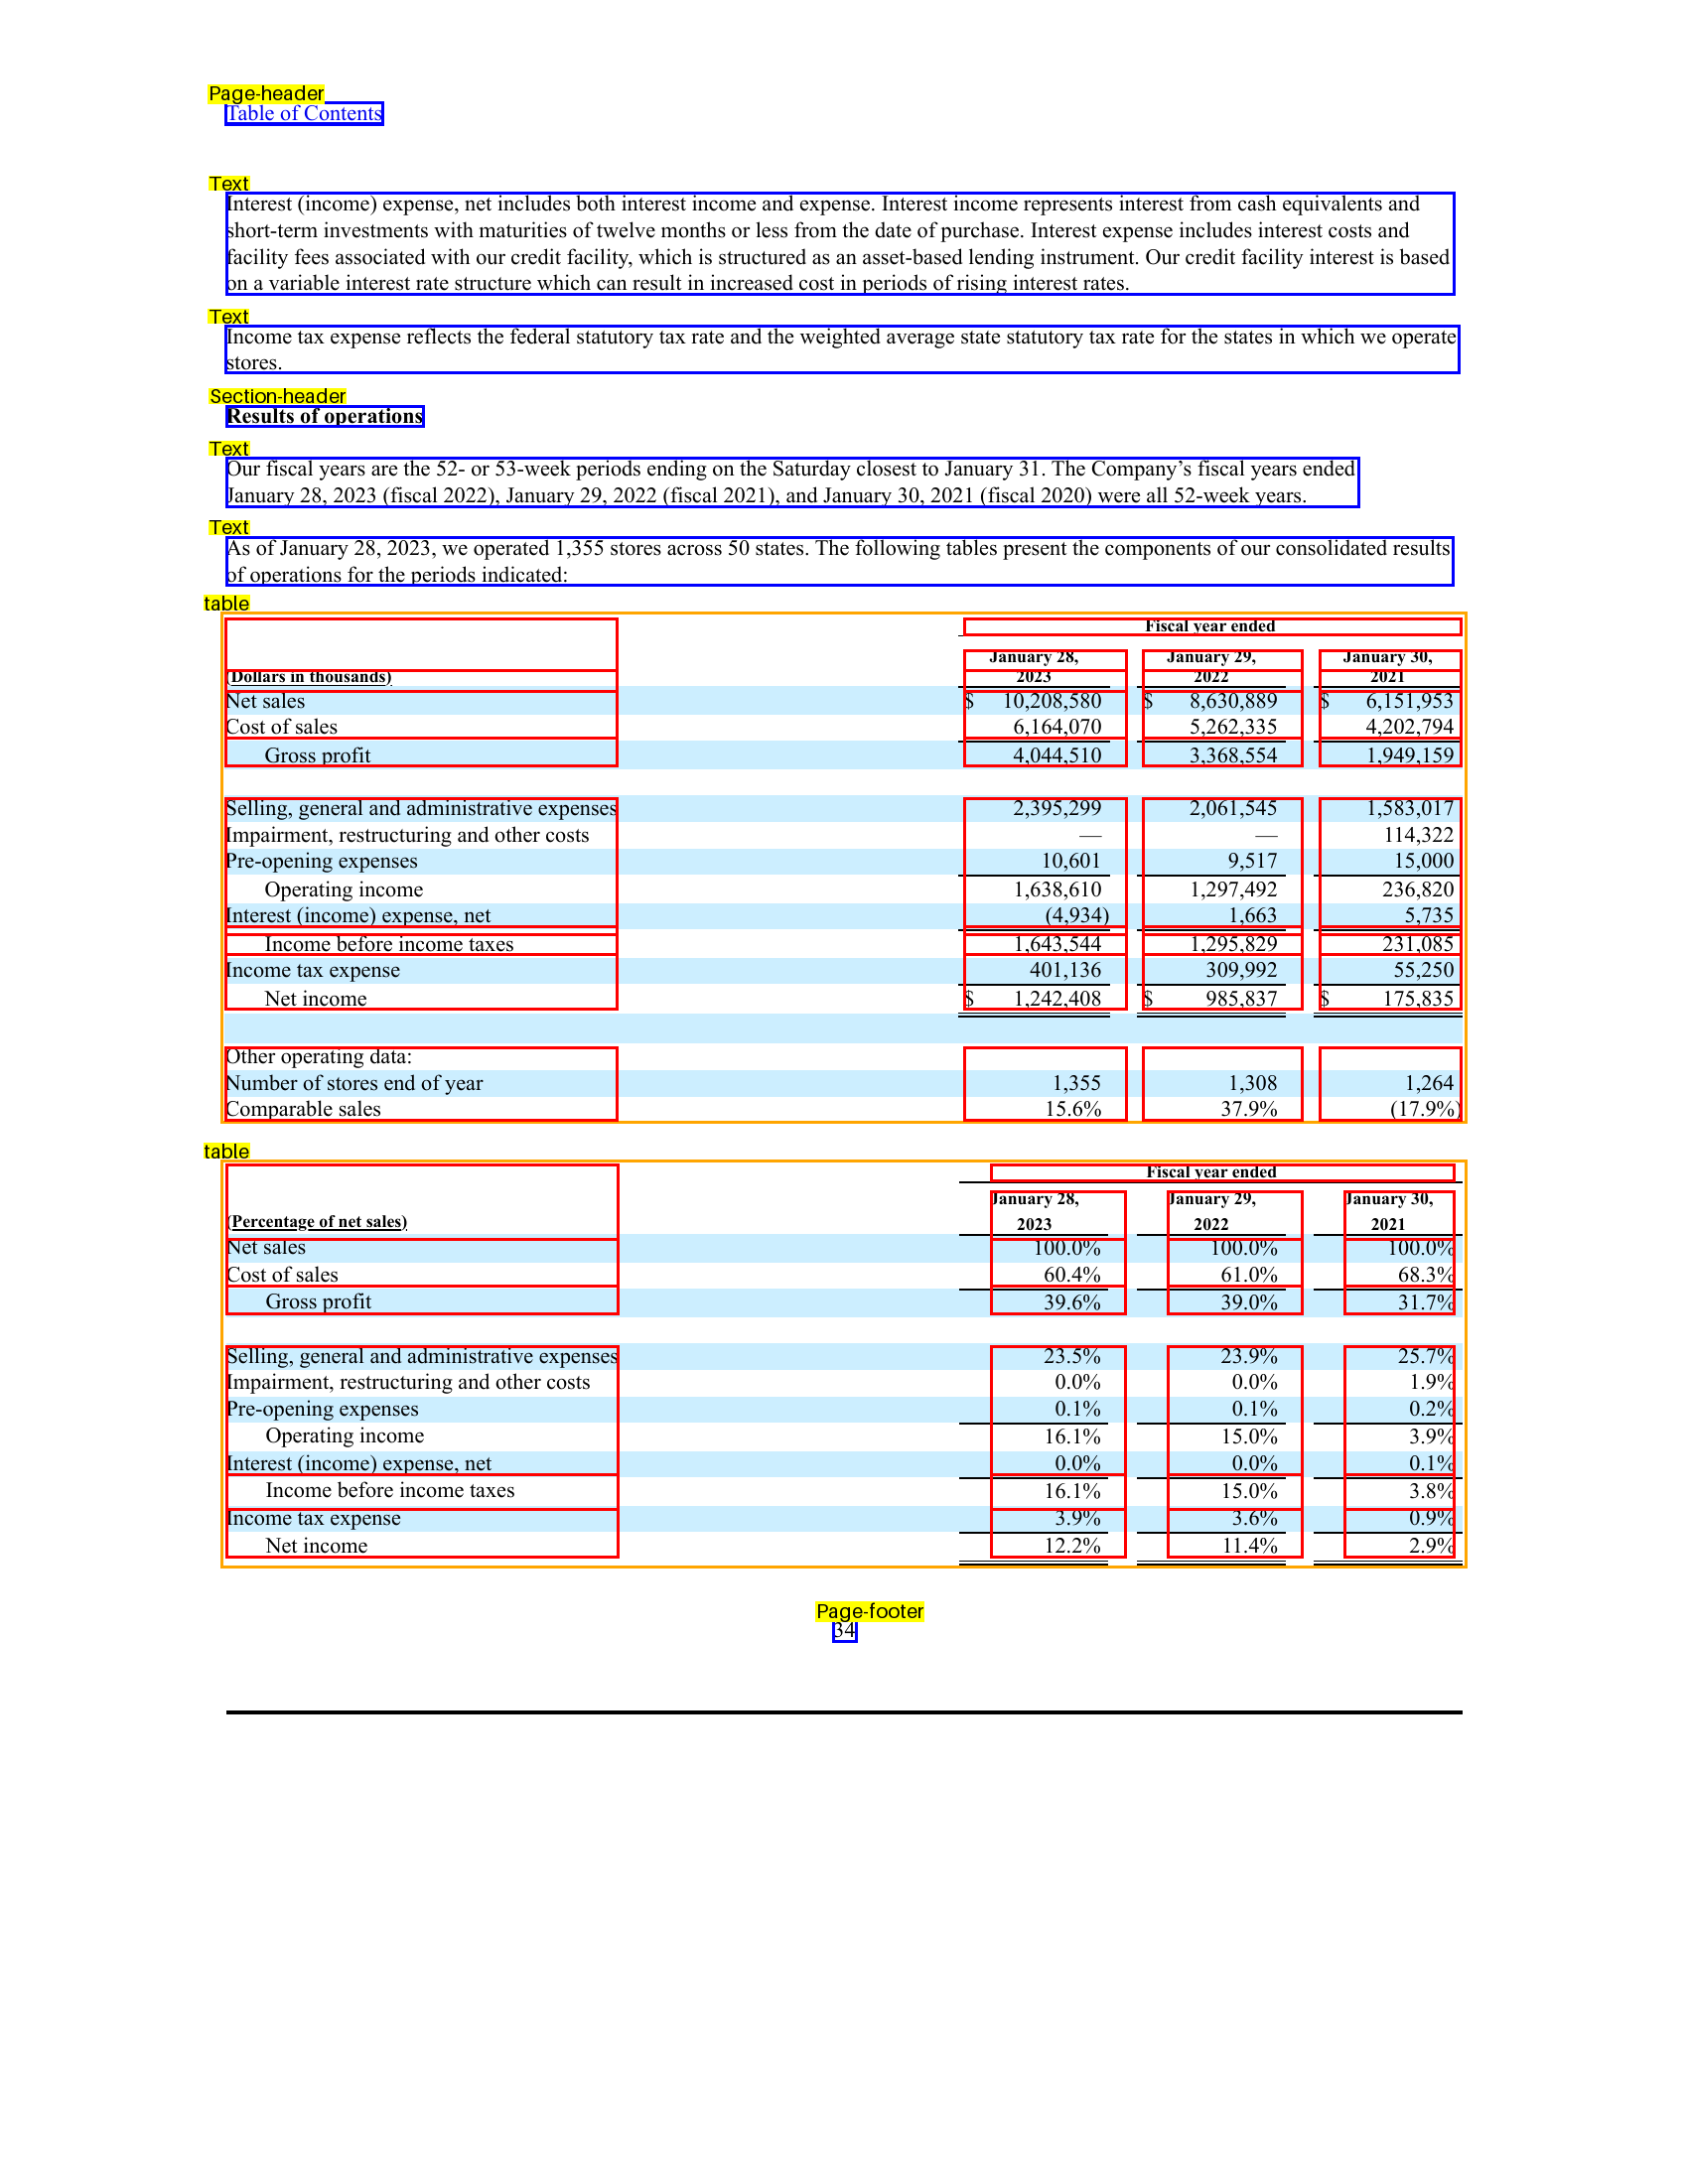

In [ ]:
# Page with text and table, Foot Locker 8K
partition_visualize("/app/work/docker_volume/visualize_pdfs/ultabeauty_table.pdf", True)

In [ ]:
def textract_partition_visualize(paths, thrshld=0.3):
    if len(paths) == 0:
        print("WARNING: import_pdf called with empty paths")
    
    if (
        (isinstance(paths, str) or isinstance(paths, Path)) 
        and Path(paths).exists() and Path(paths).is_dir()
        and len(list(Path(paths).iterdir())) == 0
    ):
        print("WARNING: import_pdf called with empty directory")
    
    ctx = sycamore.init()
    pdf_docset = ctx.read.binary(paths, binary_format="pdf", filter_paths_by_extension=False)
    # partitioned_docset = pdf_docset.partition(partitioner=SycamorePartitioner(threshold=thrshld), table_extractor=TextractTableExtractor(profile_name="AdministratorAccess-237550789389", region_name="us-east-1", s3_upload_root="s3://aanya-textract"), compute=ActorPoolStrategy(size=1))
    
    # show_pages(partitioned_docset, limit=1)
    doc = pdf_docset.take(1)[0]
    table_extractor=TextractTableExtractor(profile_name="AdministratorAccess-237550789389", region_name="us-east-1", s3_upload_root="s3://aanya-textract")
    textract_result = table_extractor.get_textract_result(doc)
    # tables = table_extractor.get_tables_from_textract_result(textract_result)
    for table in textract_result.tables:
        table.to_excel("/home/admin/sycamore/examples/visualize_pdfs/test.xlsx")

In [ ]:
textract_partition_visualize("/home/admin/sycamore/examples/visualize_pdfs/3m_1.pdf", 0.35)

2024-07-09 19:38:45,261	INFO streaming_executor.py:112 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-07-09_16-32-36_503269_2681/logs/ray-data
2024-07-09 19:38:45,261	INFO streaming_executor.py:113 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadBinary] -> TaskPoolMapOperator[Map(BinaryScan._to_document)]


- ReadBinary->SplitBlocks(16) 1:   0%|          | 0/1 [00:00<?, ?it/s]

- Map(BinaryScan._to_document) 2:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
def ocr_partition_visualize(paths, thrshld=0.3):
    if len(paths) == 0:
        print("WARNING: import_pdf called with empty paths")
    
    if (
        (isinstance(paths, str) or isinstance(paths, Path)) 
        and Path(paths).exists() and Path(paths).is_dir()
        and len(list(Path(paths).iterdir())) == 0
    ):
        print("WARNING: import_pdf called with empty directory")
    
    ctx = sycamore.init()
    pdf_docset = ctx.read.binary(paths, binary_format="pdf", filter_paths_by_extension=False)
    partitioned_docset = pdf_docset.partition(partitioner=SycamorePartitioner(use_ocr=True, extract_table_structure=True, threshold=thrshld), compute=ActorPoolStrategy(size=1))
    
    show_pages(partitioned_docset, limit=1)

AAAAAAAAA


2024-07-09 23:02:05,850	WARNING util.py:560 -- The argument ``compute`` is deprecated in Ray 2.9. Please specify argument ``concurrency`` instead. For more information, see https://docs.ray.io/en/master/data/transforming-data.html#stateful-transforms.
2024-07-09 23:02:05,856	INFO streaming_executor.py:112 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-07-09_22-50-51_443332_98404/logs/ray-data
2024-07-09 23:02:05,856	INFO streaming_executor.py:113 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadBinary] -> TaskPoolMapOperator[Map(BinaryScan._to_document)] -> ActorPoolMapOperator[MapBatches(BaseMapTransformCallable___wrap)] -> TaskPoolMapOperator[MapBatches(split_and_convert_to_image)] -> LimitOperator[limit=1] -> TaskPoolMapOperator[MapBatches(DrawBoxes)]


- ReadBinary->SplitBlocks(16) 1:   0%|          | 0/1 [00:00<?, ?it/s]

- Map(BinaryScan._to_document) 2:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(BaseMapTransformCallable___wrap) 3:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(split_and_convert_to_image) 4:   0%|          | 0/1 [00:00<?, ?it/s]

- limit=1 5:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(DrawBoxes) 6:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

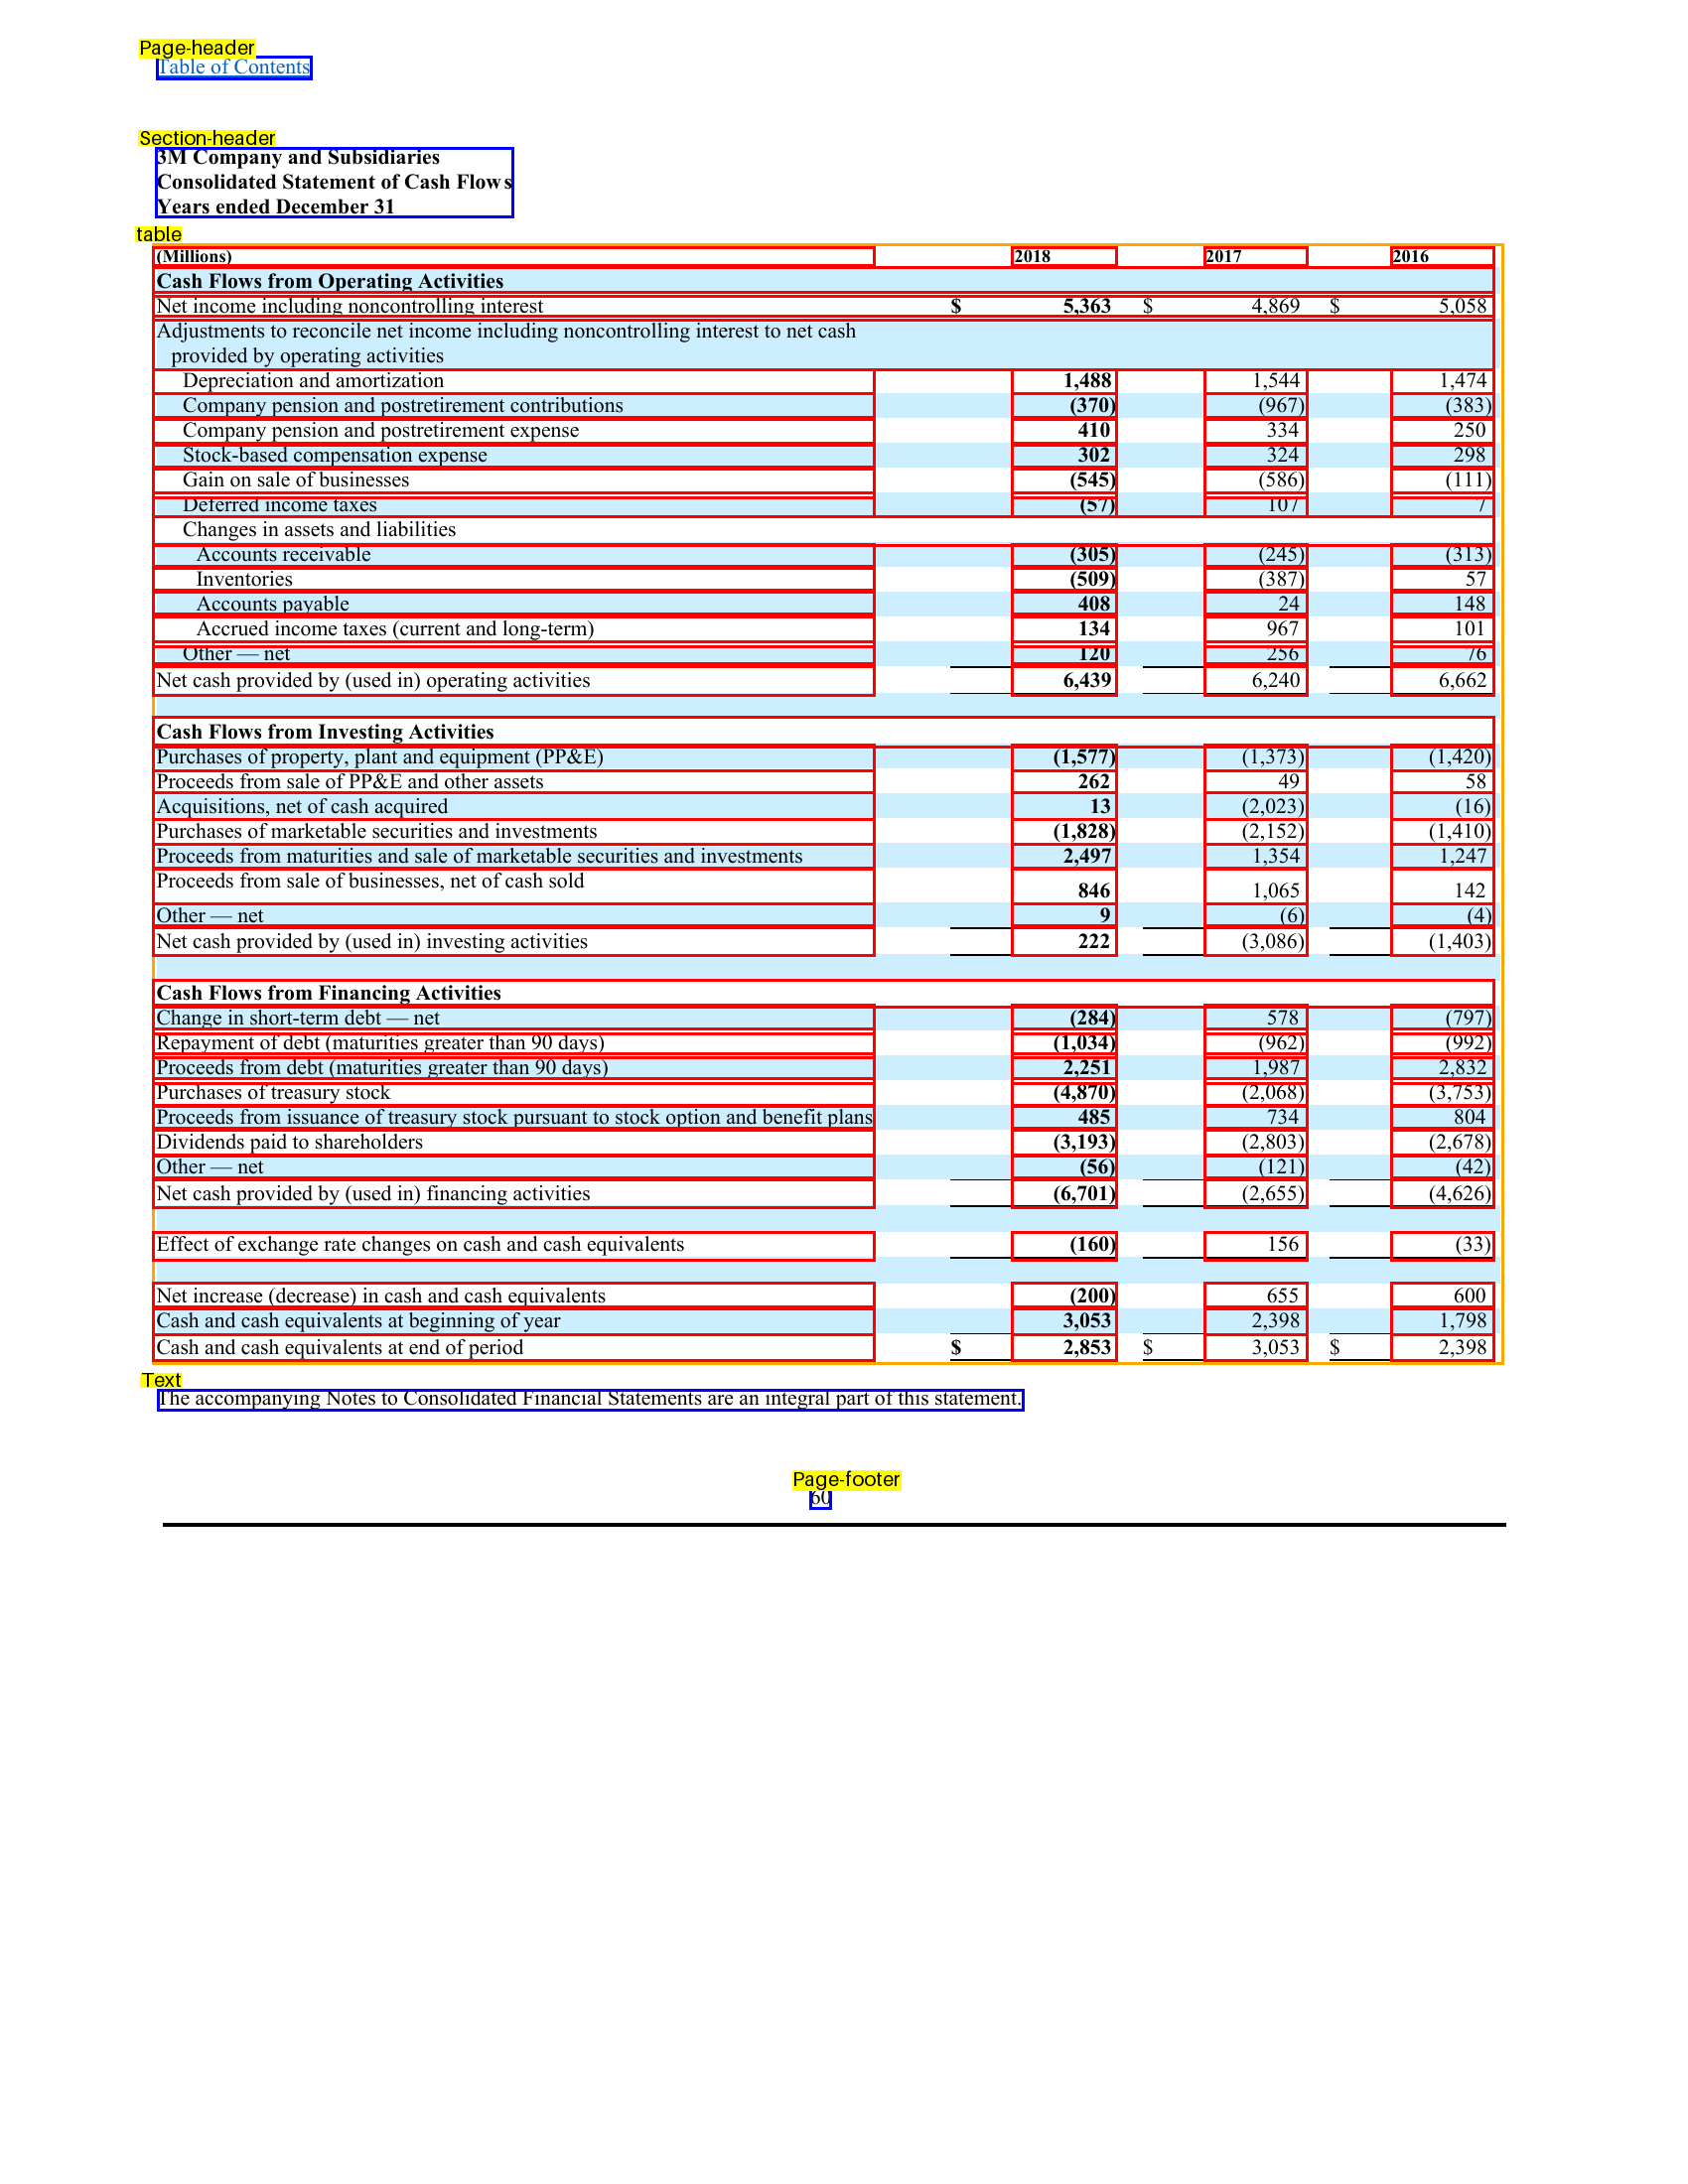

In [ ]:
ocr_partition_visualize("/home/admin/sycamore/examples/visualize_pdfs/3m_1.pdf", 0.35)